<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharoptosis_dryeye_20250701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries loaded.
File loaded successfully.
Filtered (SPK pre==0): (102, 32)


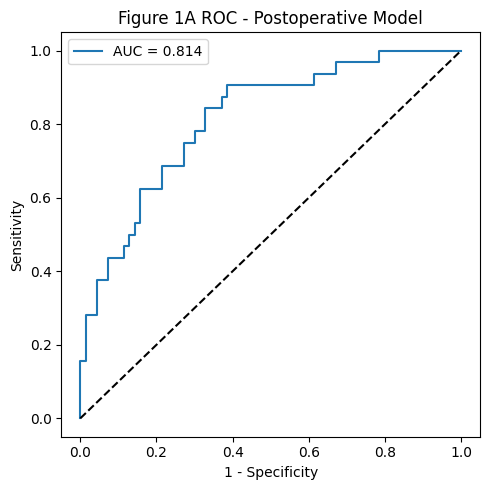


--- Generating Forest Plot and OR Table using GEE with Robust Quartiling ---

      GEE-based Odds Ratio Table (Robust Quartiling)

--- Predictor Variable: BUT post ---


,Quartile,Range,Odds Ratio,95% CI,P-value
0,Q1,2.00–3.00,4.75,1.31 – 17.23,0.018
1,Q2,3.00–4.00,6.04,1.78 – 20.45,0.004
2,Q3,4.00–7.00,0.74,0.18 – 2.94,0.666
3,Q4 (Reference),8.00–10.00,1.00,1.00 – 1.00,---



--- Predictor Variable: BUT pre ---


,Quartile,Range,Odds Ratio,95% CI,P-value
0,Q1,1.00–3.00,2.27,0.65 – 7.94,0.199
1,Q2,3.00–3.00,2.41,0.61 – 9.52,0.209
2,Q3,3.00–5.00,2.41,0.67 – 8.75,0.180
3,Q4 (Reference),5.00–10.00,1.00,1.00 – 1.00,---



--- Predictor Variable: MRD-1 pre ---


,Quartile,Range,Odds Ratio,95% CI,P-value
0,Q1,-4.00–0.00,4.11,0.93 – 18.17,0.063
1,Q2,0.50–0.50,4.39,0.61 – 31.34,0.140
2,Q3,0.50–1.00,1.73,0.32 – 9.45,0.528
3,Q4 (Reference),1.00–3.00,1.00,1.00 – 1.00,---



--- Predictor Variable: MRD-2 pre ---


,Quartile,Range,Odds Ratio,95% CI,P-value
0,Q1 (Reference),3.00–4.50,1.00,1.00 – 1.00,---
1,Q2,4.50–5.00,1.26,0.50 – 3.19,0.625
2,Q3,5.00–5.50,1.08,0.31 – 3.70,0.907
3,Q4,5.50–6.50,1.70,0.67 – 4.37,0.267



--- Predictor Variable: levator_function pre ---


,Quartile,Range,Odds Ratio,95% CI,P-value
0,Q1,5.00–8.00,6.54,1.83 – 23.38,0.004
1,Q2,8.00–10.00,2.19,0.60 – 8.03,0.237
2,Q3,10.00–11.00,2.18,0.63 – 7.51,0.217
3,Q4 (Reference),11.00–16.00,1.00,1.00 – 1.00,---



--- Predictor Variable: ΔMRD-1 ---


,Quartile,Range,Odds Ratio,95% CI,P-value
0,Q1 (Reference),0.00–2.00,1.00,1.00 – 1.00,---
1,Q2,2.00–2.50,3.58,0.98 – 13.09,0.054
2,Q3,2.50–3.50,5.25,1.38 – 19.90,0.015
3,Q4,3.50–7.00,5.78,1.65 – 20.31,0.006


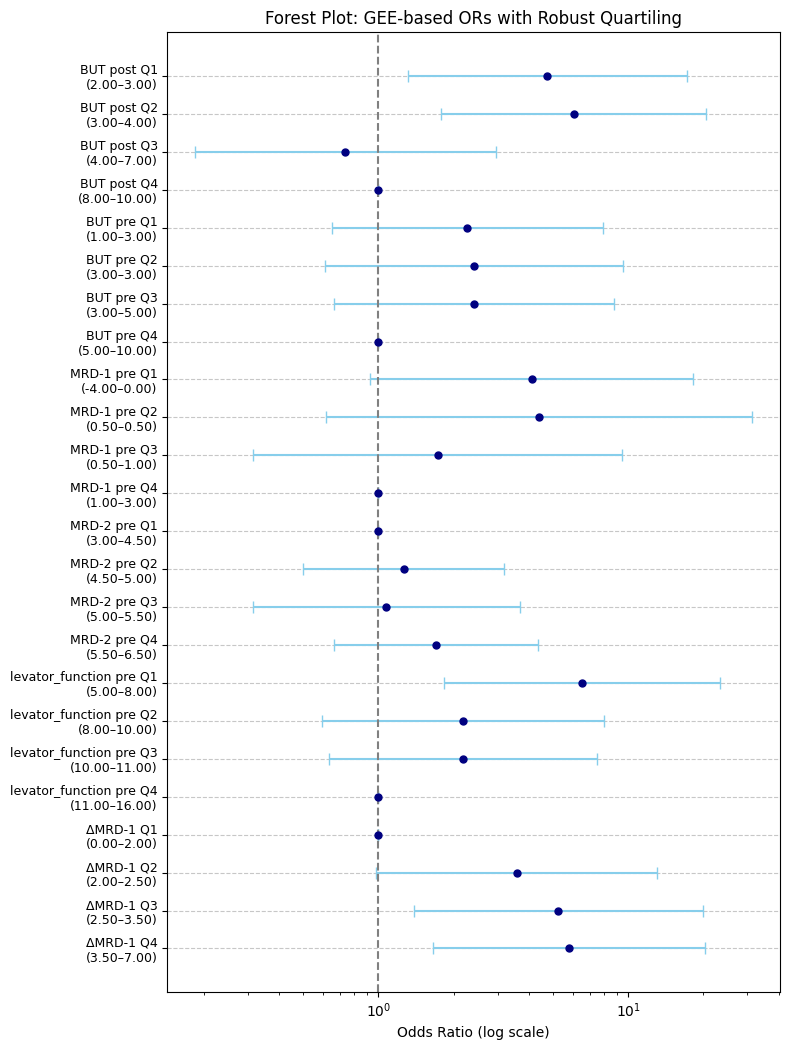


解析完了。


In [ ]:
# ===================================================================
# 眼瞼下垂術後 SPK リスク解析：統合最終版スクリプト
#
# 1. 頑健なカテゴリ分け手法（動的分割数、重複対応）を採用
# 2. 左右眼の相関を考慮した GEE モデルでオッズ比を算出
# 3. ROC曲線、Forest Plot、各種サマリーテーブルを出力
# ===================================================================

# 1) ライブラリ
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from IPython.display import display
warnings.filterwarnings('ignore')
print("Libraries loaded.")

# 2) ファイル設定と読み込み
# Google Colab を使用する場合は、以下のコメントを解除して実行してください
# from google.colab import drive
# drive.mount('/content/drive')

FILEPATH = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
SHEET = "対象症例sides"
ID_COL = "ID"
SEX_COL = "sex"

# 3) 読み込み & 前処理
try:
    df_all = pd.read_excel(FILEPATH, sheet_name=SHEET, header=0)
    print("File loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file was not found at {FILEPATH}")
    print("Please check the file path and ensure it is accessible.")
    exit()

df_all[ID_COL] = df_all[ID_COL].astype(str).str.strip().replace({"": np.nan}).ffill()

if df_all[SEX_COL].dtype.kind in "OS":
    df_all[SEX_COL] = (
        df_all[SEX_COL].astype(str).str.strip().replace({"": np.nan})
        .map({"M": 1, "F": 0, "男": 1, "女": 0, "male": 1, "female": 0, "1": 1, "0": 0})
    )

num_cols = [
    "age", "MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M",
    "levator_function pre", "BUT pre", "BUT post",
    "点眼薬 pre", "点眼薬 post", SEX_COL, "SPK pre", "SPK post"
]
for c in num_cols:
    if c in df_all.columns:
        df_all[c] = pd.to_numeric(df_all[c], errors='coerce')

df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]

# 4) 術前 SPK=0 でフィルタ
df = df_all[df_all["SPK pre"] == 0].copy()
print(f"Filtered (SPK pre==0): {df.shape}")

# ===============================
# Figure 1A：術後モデルのROC曲線 (参考: ロジスティック回帰)
# ===============================
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "MRD-2 pre", "BUT pre", "BUT post"]
df_post = df[["SPK post"] + post_cols].dropna()

if not df_post.empty:
    X_post = sm.add_constant(df_post[post_cols])
    y_post = df_post["SPK post"]
    post_model = sm.Logit(y_post, X_post).fit(disp=False)
    y_prob_post = post_model.predict(X_post)
    fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
    auc_p = roc_auc_score(y_post, y_prob_post)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr_p, tpr_p, label=f"AUC = {auc_p:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title("Figure 1A ROC - Postoperative Model")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Skipping Figure 1A: Not enough data.")

# ===============================
# GEEによるForest Plotとオッズ比テーブルの作成
# ★★★ 新しい頑健なカテゴリ分け手法を適用 ★★★
# ===============================
print("\n--- Generating Forest Plot and OR Table using GEE with Robust Quartiling ---")
# 解析対象とする連続変数
predictors = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "BUT post", "levator_function pre", "MRD-2 pre"]
forest_data_gee = []

for var in predictors:
    # GEE解析に必要な列（ID, 目的変数, 説明変数）を抽出し、欠損値を持つ行を削除
    df_q = df[[ID_COL, "SPK post", var]].dropna().copy()

    # --- ここからが新しい頑健なカテゴリ分けロジック ---
    # 1. 動的に分割数を決定
    n_quantiles = min(4, df_q[var].nunique())
    if n_quantiles < 2:
        print(f"Skipping '{var}': Not enough unique values ({df_q[var].nunique()}) to create groups.")
        continue

    # 2. ラベルを作成し、重複を許容してカテゴリ分けを実行
    labels = [f"Q{i+1}" for i in range(n_quantiles)]
    try:
        df_q["quartile"] = pd.qcut(df_q[var].rank(method="first"), n_quantiles, labels=labels, duplicates='drop')
    except Exception as e:
        print(f"Skipping '{var}': Quartile creation failed. Error: {e}")
        continue
    # --- ロジックここまで ---

    # 実際に作成されたカテゴリ名と範囲を取得
    existing_quartiles = df_q["quartile"].cat.categories.tolist()
    ranges = {q: f"{df_q[df_q['quartile']==q][var].min():.2f}–{df_q[df_q['quartile']==q][var].max():.2f}" for q in existing_quartiles}

    # 基準群を決定（リスク最小群を想定）
    if var in ["ΔMRD-1", "MRD-2 pre"]:
        ref_q = "Q1"
    else:
        ref_q = existing_quartiles[-1] # 一番最後のカテゴリ (例: Q4 or Q3)

    # 基準群がカテゴリに存在するか確認（'duplicates=drop'で消えることがあるため）
    if ref_q not in existing_quartiles:
        ref_q = existing_quartiles[0] if var in ["ΔMRD-1", "MRD-2 pre"] else existing_quartiles[-1]
        print(f" - Note for '{var}': Original ref_q was dropped, using '{ref_q}' as fallback.")

    # GEEモデルの実行
    try:
        formula = f"Q('SPK post') ~ C(Q('quartile'), Treatment(reference='{ref_q}'))"
        gee_model = GEE.from_formula(
            formula, groups=df_q[ID_COL], data=df_q,
            family=Binomial(), cov_struct=Exchangeable()
        ).fit()

        # 結果を抽出
        results = pd.DataFrame({'OR': np.exp(gee_model.params), 'CI_low': np.exp(gee_model.conf_int())[0], 'CI_high': np.exp(gee_model.conf_int())[1], 'p_value': gee_model.pvalues}).reset_index()
        results = results[results['index'] != 'Intercept']
        results['Quartile'] = results['index'].str.extract(r"\[T\.(.*)\]")[0]

        # 基準カテゴリと解析結果を格納
        forest_data_gee.append((var, ref_q, ranges[ref_q], 1.0, 1.0, 1.0, np.nan))
        for _, row in results.iterrows():
            q = row['Quartile']
            forest_data_gee.append((var, q, ranges[q], row['OR'], row['CI_low'], row['CI_high'], row['p_value']))

    except Exception as e:
        print(f"GEE model failed for '{var}'. Error: {e}")

# ==============================================================
# GEEオッズ比の結果を表と図で可視化
# ==============================================================
if forest_data_gee:
    forest_df = pd.DataFrame(forest_data_gee, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "p_value"])

    # --- オッズ比テーブルの表示 ---
    print("\n" + "="*60)
    print("      GEE-based Odds Ratio Table (Robust Quartiling)")
    print("="*60)
    display_table = forest_df.copy()
    display_table['Odds Ratio'] = display_table['OR'].apply(lambda x: f"{x:.2f}")
    display_table['95% CI'] = display_table.apply(lambda row: f"{row['CI_low']:.2f} – {row['CI_high']:.2f}", axis=1)
    display_table['P-value'] = display_table['p_value'].apply(lambda p: f"{p:.3f}" if pd.notna(p) else "---")
    quartile_order = {"Q1": 0, "Q2": 1, "Q3": 2, "Q4": 3}
    display_table['quartile_sort'] = display_table['Quartile'].map(quartile_order)

    for var_name, group in display_table.sort_values(by=['Variable', 'quartile_sort']).groupby('Variable', sort=False):
        print(f"\n--- Predictor Variable: {var_name} ---")
        ref_q = group[group['OR']==1.0]['Quartile'].iloc[0] # 基準カテゴリを特定
        final_table = group[['Quartile', 'Range', 'Odds Ratio', '95% CI', 'P-value']].copy()
        final_table['Quartile'] = final_table['Quartile'].apply(lambda q: f"{q} (Reference)" if q == ref_q else q)
        display(final_table.reset_index(drop=True))

    # --- フォレストプロットの描画 ---
    forest_df["Label"] = forest_df.apply(lambda row: f"{row['Variable']} {row['Quartile']}\n({row['Range']})", axis=1)
    forest_df['quartile_sort'] = forest_df['Quartile'].map(quartile_order)
    forest_df_sorted = forest_df.sort_values(by=['Variable', 'quartile_sort'])

    plt.figure(figsize=(8, len(forest_df) * 0.4 + 1))
    y_pos = np.arange(len(forest_df_sorted))[::-1]
    xerr = [forest_df_sorted["OR"] - forest_df_sorted["CI_low"], forest_df_sorted["CI_high"] - forest_df_sorted["OR"]]
    plt.errorbar(forest_df_sorted["OR"], y_pos, xerr=xerr, fmt='o', color='navy', ecolor='skyblue', capsize=4, markersize=5)
    plt.axvline(1, color='gray', linestyle='--')
    plt.yticks(y_pos, forest_df_sorted["Label"], fontsize=9)
    plt.xscale("log")
    plt.xlabel("Odds Ratio (log scale)")
    plt.title("Forest Plot: GEE-based ORs with Robust Quartiling")
    plt.tight_layout(); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

else:
    print("\nCould not generate data for Forest Plot and Table.")

print("\n解析完了。")

### GEE解析

In [ ]:
# =============================================================
# 眼瞼下垂術後 SPK リスク解析：GEE スクリプト 〈GEE_varSelect〉
#   ・左右眼を同一患者クラスタ（Exchangeable GEE）
#   ・【単変量用フル候補】と【多変量投入用】を分離して指定
# =============================================================

# 0)  Google Drive（Colab の場合だけ）
# from google.colab import drive
# drive.mount('/content/drive')

# 1)  ライブラリ
import os, warnings, numpy as np, pandas as pd
from scipy.stats import shapiro
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
from IPython.display import display
warnings.filterwarnings('ignore')
print("Libraries loaded.")

# 2)  ファイル設定
FILEPATH   = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
SHEET      = "対象症例sides"
ID_COL     = "ID"
SEX_COL    = "sex"
DRUG_PRE   = "点眼薬 pre"
DRUG_POST  = "点眼薬 post"

# 3)  読み込み & 前処理（ID 前方補完・sex を 0/1 へ）
df_all = pd.read_excel(FILEPATH, sheet_name=SHEET, header=0)
df_all[ID_COL] = df_all[ID_COL].astype(str).str.strip().replace({"": np.nan}).ffill()

if df_all[SEX_COL].dtype.kind in "OS":  # 文字列なら 0/1 にマップ
    df_all[SEX_COL] = (
        df_all[SEX_COL].astype(str).str.strip().replace({"": np.nan})
               .map({"M":1,"F":0,"男":1,"女":0,"male":1,"female":0,"1":1,"0":0})
)

num_cols = [
    "age",
    "MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M",
    "levator_function pre", "BUT pre",
    DRUG_PRE, DRUG_POST,
    SEX_COL, "SPK pre", "SPK post"
]
for c in num_cols:
    if c in df_all.columns:
        df_all[c] = pd.to_numeric(df_all[c], errors='coerce')

# ΔMRD
df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]

# 4)  術前 SPK=0 でフィルタ
df = df_all[df_all["SPK pre"] == 0].copy()
print("Filtered (SPK pre==0):", df.shape)

# -----------------------------------------------------------------------
# ★ ここで単変量候補と多変量投入変数を自由に編集 ★
# -----------------------------------------------------------------------
CANDIDATES = [
    "age", SEX_COL, "side",                           # 単変量に回すフルセット
    "MRD-1 pre", "MRD-1 3M", "ΔMRD-1",
    "MRD-2 pre", "MRD-2 3M", "ΔMRD-2",
    "levator_function pre", "BUT pre",
    DRUG_PRE, DRUG_POST
]

MULTI_VARS = [                                # 多変量に実際に入れる変数
    "age", SEX_COL,"side",
    "MRD-1 pre", "ΔMRD-1", "MRD-2 pre", "ΔMRD-2",
    "levator_function pre", "BUT pre",
    DRUG_PRE, DRUG_POST
]
MULTI_VARS = [                                # 多変量に実際に入れる変数
    "age", SEX_COL,
    "ΔMRD-1", "MRD-2 pre", "BUT pre",
    DRUG_PRE, DRUG_POST
]
# -----------------------------------------------------------------------

# 5)  記述統計
desc = df[CANDIDATES].describe(percentiles=[.25,.5,.75]).T
desc["Missing"] = df[CANDIDATES].isna().sum()
display(desc.round(2))

# 6)  Shapiro-Wilk（参考）
for v in CANDIDATES:
    d = df[v].dropna()
    if len(d) >= 3:
        W, p = shapiro(d)
        print(f"{v:<22}: W={W:.3f}, p={p:.4f}")

# 7)  単変量 GEE
uni_rows = []
for v in CANDIDATES:
    sub = df[[ID_COL, "SPK post", v]].dropna()
    if sub[v].nunique() < 2:           # 定数列スキップ
        continue
    g = GEE.from_formula(
        f"Q('SPK post') ~ Q('{v}')",
        groups=ID_COL, data=sub,
        family=Binomial(), cov_struct=Exchangeable()).fit()
    b, se = g.params[1], g.bse[1]
    uni_rows.append([v, np.exp(b), *np.exp(b + np.array([-1.96, 1.96])*se), g.pvalues[1]])
uni_df = pd.DataFrame(uni_rows, columns=["Variable","OR","CI_low","CI_high","p"])
print("\n─ Univariate GEE ─"); display(uni_df.round(3))

# 8)  多変量 GEE（関数化）
def run_multivariate_gee(var_list):
    sub = df[[ID_COL, "SPK post"] + var_list].dropna()
    print(f"\n多変量用データ行数: {sub.shape[0]}")
    if sub.shape[0] < 5:
        raise ValueError("行数不足：欠損補完または変数見直しを。")
    formula = "Q('SPK post') ~ " + " + ".join([f"Q('{v}')" for v in var_list])
    model = GEE.from_formula(formula,
                             groups=ID_COL,
                             data=sub,
                             family=Binomial(),
                             cov_struct=Exchangeable()).fit()
    return model

gee_model = run_multivariate_gee(MULTI_VARS)
print("\n─ Multivariate GEE ─"); print(gee_model.summary())

print("\n解析完了。")


Libraries loaded.
Filtered (SPK pre==0): (102, 32)


,count,mean,std,min,25%,50%,75%,max,Missing
age,102.0,76.20,8.33,42.0,71.00,75.5,83.0,94.0,0
sex,102.0,0.46,0.50,0.0,0.00,0.0,1.0,1.0,0
MRD-1 pre,102.0,0.50,1.19,-4.0,0.12,0.5,1.0,3.0,0
MRD-1 3M,102.0,3.24,0.97,1.0,3.00,3.0,4.0,5.5,0
ΔMRD-1,102.0,2.74,1.33,0.0,2.00,2.5,3.5,7.0,0
MRD-2 pre,102.0,4.86,0.69,3.0,4.50,5.0,5.5,6.5,0
MRD-2 3M,102.0,4.87,0.60,3.5,4.50,5.0,5.0,6.0,0
ΔMRD-2,102.0,0.01,0.39,-1.0,0.00,0.0,0.0,1.0,0
levator_function pre,102.0,9.53,2.20,5.0,8.00,10.0,11.0,16.0,0
BUT pre,102.0,4.57,2.75,1.0,3.00,3.0,5.0,10.0,0


age                   : W=0.963, p=0.0059
sex                   : W=0.634, p=0.0000
side                  : W=0.636, p=0.0000
MRD-1 pre             : W=0.911, p=0.0000
MRD-1 3M              : W=0.952, p=0.0009
ΔMRD-1                : W=0.972, p=0.0314
MRD-2 pre             : W=0.946, p=0.0004
MRD-2 3M              : W=0.920, p=0.0000
ΔMRD-2                : W=0.828, p=0.0000
levator_function pre  : W=0.972, p=0.0304
BUT pre               : W=0.798, p=0.0000
点眼薬 pre               : W=0.584, p=0.0000
点眼薬 post              : W=0.584, p=0.0000

─ Univariate GEE ─


,Variable,OR,CI_low,CI_high,p
0,age,1.036,0.988,1.086,0.144
1,sex,1.044,0.532,2.052,0.900
2,side,1.192,0.666,2.135,0.553
3,MRD-1 pre,0.717,0.494,1.041,0.080
4,MRD-1 3M,1.193,0.702,2.027,0.514
5,ΔMRD-1,1.451,1.088,1.936,0.011
6,MRD-2 pre,1.568,0.952,2.582,0.078
7,MRD-2 3M,1.415,0.768,2.607,0.266
8,ΔMRD-2,0.558,0.163,1.913,0.353
9,levator_function pre,0.695,0.588,0.821,0.000



多変量用データ行数: 102

─ Multivariate GEE ─
                               GEE Regression Results                              
Dep. Variable:               Q('SPK post')   No. Observations:                  102
Model:                                 GEE   No. clusters:                       59
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  44
Family:                           Binomial   Mean cluster size:                 1.7
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Fri, 04 Jul 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         09:22:31
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.1368      2.096    

# 眼瞼下垂術後SPKリスクスコアリングシステム（術前因子のみ）解説

## 1. スコアリングシステムの目的

このスコアリングシステムの主な目的は、眼瞼下垂手術を受ける患者さんの**術前の情報のみ**（※注意点あり）を用いて、手術後に**SPK（点状表層角膜症）を発症するリスクを予測すること**です。

これにより、術前からリスクが高い患者さんを特定し、術後のドライアイ管理（点眼の強化、フォローアップの頻度調整など）をより重点的に行うための判断材料を提供することを目指しています。

## 2. スコアリングの根拠

本スコアリングシステムは、実施された統計解析結果、特に**フォレストプロット（Figure 2）**に基づいています。フォレストプロットでは、各因子（例：MRD-1 pre, ΔMRD-1, BUT pre）を値に基づいて四分位に分割し、各グループの術後SPK発症との関連性（オッズ比）を視覚化しています。

この結果から、術後SPKリスク上昇と**関連が強い（オッズ比 > 1 かつ p値が比較的小さい）**と判断された因子とその閾値（カットオフ値）を抽出し、スコアリング項目として採用しました。

## 3. スコアリングの構成

以下の4つの術前（※）リスク因子と、それぞれのカットオフ値に基づいてスコアが計算されます。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 | 根拠（フォレストプロット等）                          |
| :----------------------- | :----------------- | :--------- | :-------------------------------------------------- |
| **MRD-1 pre**            | `< 0.5 mm`         | **2点**    | Q1 (≤0.0), Q2 (=0.5)でORが高い傾向 (p=0.064, 0.034) |
| **ΔMRD-1**               | `>= 2.0 mm`        | 1点        | Q2 (≥2.0)以降でORが高い (p=0.097, 0.027, 0.027)     |
| **BUT pre**              | `< 5 秒`           | 1点        | Q1(<3), Q2(=3), Q3(<5)でORが高い傾向 (p=0.349, 0.220) |
| **levator function pre** | `< 8 mm`           | 1点        | Q1(<8)でORが有意に高い (p=0.008)                     |
| **合計スコア**           |                    | **0点 〜 5点** |                                                     |

**※ ΔMRD-1 に関する重要な注意点:**
現在の計算では、`ΔMRD-1` は `MRD-1 3M - MRD-1 pre` として算出されています。これは**術後3ヶ月時点のデータ**を含むため、厳密には**「術前の情報のみ」を用いたスコアではありません**。この点については以下の解釈が考えられます。

1.  **術後予測モデル因子としての評価:** このスコアは術後3ヶ月までの情報を含めた上でのSPKリスク評価モデルの一部とみなす。
2.  **目標挙上量の代理:** ΔMRD-1を、術前に計画された、あるいは期待されるMRD-1の変化量の代理指標として扱う。もし術前に目標挙上量を決定している場合、その値で代替すれば純粋な術前スコアとなり得る。

このスコアを解釈・利用する際には、この点を十分に理解する必要があります。純粋な「術前予測スコア」を目指す場合、ΔMRD-1を除外するか、術前に決定可能な値（例：目標挙上量）に置き換えるなどの修正を検討する価値があります。

**点数配分について:**
`MRD-1 pre < 0.5` に2点が割り当てられているのは、フォレストプロット結果（低い四分位でのORの高さ）や、臨床的な重要度（術前MRD-1低値が特に重要）を反映していると考えられます。他の因子はリスク上昇が見られた閾値で1点としています。

## 4. スコアの解釈と利用

*   **リスク層別化:** 計算された合計スコア（0〜5点）が高いほど、術後SPKを発症するリスクが高いことを示唆します。
*   **発生率の目安:** スコア別のSPK発生率（解析結果の表やグラフ参照）は、各スコアを持つ患者群における実際のSPK発症割合の目安となります（例：「スコア4点の群では40.0%がSPKを発症」）。
*   **予測性能 (AUC):** ROC曲線下面積（AUC）は、スコアシステム全体の予測精度を示します。今回の解析ではAUC=0.659であり、これは中程度の識別能力（modest discriminative ability）を示唆します（AUC 1.0が完璧な予測、0.5がランダム）。
*   **カットオフ値:** Youden Indexに基づく最適なカットオフ値（解析結果では「≥ 3点」）は、高リスク群と低リスク群を分類する際の参考閾値となります。この閾値を用いると、感度0.438（SPK発症者の約44%を高リスクと判定）、特異度0.771（SPK非発症者の約77%を低リスクと判定）となりました。実際の運用では、感度と特異度のバランスを考慮してカットオフ値を決定する必要があります。

## 5. 限界と注意点

*   **データセット依存性 (外的妥当性):** このスコアは特定のデータセットに基づいて開発されたため、異なる患者集団（人種、年齢構成、術式など）に適用した場合、同じ性能が得られるとは限りません。
*   **他の因子の影響:** スコアに含まれていない他の因子（年齢、性別、涙液量、基礎疾患、薬剤使用など）や、術中・術後の要因もSPKリスクに影響を与える可能性があります。
*   **臨床判断の補助:** 本スコアはリスク評価ツールであり、確定診断を行うものではありません。必ず他の臨床所見と合わせて総合的に判断する必要があります。
*   **ΔMRD-1の定義の問題:** 前述の通り、ΔMRD-1に術後データが含まれている点に注意が必要です。

## 6. まとめ

この術後SPKリスクスコアリングシステムは、統計解析に基づき特定された因子を組み合わせて、患者個々のリスクレベルを評価する試みです。客観的な指標によるリスク層別化を可能にし、ハイリスク患者への重点的な管理計画立案に貢献する可能性があります。ただし、その限界（特にΔMRD-1の扱いと外的妥当性）を理解し、臨床判断を補助するツールとして慎重に活用することが求められます。

# 術後因子を加えたSPKリスクスコアリングシステム：設計方針と構成案

## 設計方針

既存の術前因子ベースのスコア（AUC 0.659）の性能（AUC 0.710）を改善するため、統計解析結果に基づき術後因子を追加した新しいスコアリングシステムを設計します。

1.  **ベースの維持:**
    *   既存スコアの構成要素（MRD-1 pre, ΔMRD-1, BUT pre, levator function pre）は、単変量解析またはForest Plotで術後SPKリスクとの関連が示唆されているため、基本的には維持します。
    *   既存の点数配分（MRD-1 pre < 0.5mm に2点、他は1点）も踏襲します。

2.  **追加因子の選定:**
    *   **BUT post** を追加します。この因子は以下の理由で選択されました。
        *   多変量解析（フルモデル、AIC選択モデル）で、術後SPKとの独立した強い関連性が一貫して示されました (AICモデル OR ≈ 0.69, p=0.002)。
        *   Forest Plot分析でも、BUT postが低い四分位（Q1: <3秒, Q2: 3-4秒）でオッズ比が有意に高いことが確認されました。
    *   **カットオフ値:** Forest Plotの結果から、BUT post `< 4秒` をリスクの閾値として設定します。
    *   **点数配分:** AICモデルにおけるBUT postのオッズ比（約0.69）が、既存スコアに含まれるlevator function pre（OR約0.63）と同程度のリスク寄与を示唆することを考慮し、`BUT post < 4秒` には**1点**を割り当てます。

3.  **含めない因子:**
    *   `MRD-2 3M` はAIC選択モデルには含まれましたが、単変量解析やForest Plotでの関連性が不明瞭であり、かつORも他の有意な因子ほど顕著ではないため、スコアの簡便性と解釈の容易さを優先し、今回は**含めません**。

4.  **ΔMRD-1の扱い:**
    *   `ΔMRD-1` は術後3ヶ月のデータを含むため、「純粋な術前スコア」ではないという注意点はありますが、既存スコアとの比較を行うため、今回の新しいスコアにも**そのまま含めます**。

## 新しいスコアリングシステムの構成（案）

上記の方針に基づき、以下の構成で新しいリスクスコア（合計0点〜6点）を定義します。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 |
| :----------------------- | :----------------- | :--------- |
| MRD-1 pre                | `< 0.5 mm`         | 2点        |
| ΔMRD-1                   | `>= 2.0 mm`        | 1点        |
| BUT pre                  | `< 5 秒`           | 1点        |
| levator function pre     | `< 8 mm`           | 1点        |
| **BUT post**             | **`< 4 秒`**       | **1点**    |
| **合計スコア**           |                    | **0点 〜 6点** |

# **Logistic regressionモデル作成**


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：Top N AUC内 最少変数モデル自動選択 + CV
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定 (変更なし)
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
# (以下、他の警告抑制も同様)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定 (変更なし)
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # 必要に応じて再マウント
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "/content/best_subset_parsimony_results" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "./best_subset_parsimony_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理 (変更なし)
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all and "MRD-1 pre" in df_all: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all and "MRD-2 pre" in df_all: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" in df_all: df = df_all[df_all["SPK pre"] == 0].copy()
else: print("Error: 'SPK pre' column not found."); exit()
if "SPK post" not in df: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. 総当たり実行関数 (変更なし)
# -------------------------------------------------------------
# run_best_subset_logit 関数は前回のままでOK (VIF計算は含まれていても問題ない)
def run_best_subset_logit(df, target_col, candidate_cols):
    # (前回のコードと同じ内容 - ここでは省略)
    results = []
    n_candidates = len(candidate_cols)
    valid_candidate_cols = [col for col in candidate_cols if col in df.columns]
    n_candidates = len(valid_candidate_cols)
    if n_candidates == 0: return pd.DataFrame()

    total_combinations = sum(1 for k in range(1, n_candidates + 1) for _ in combinations(valid_candidate_cols, k))
    print(f"Total combinations to evaluate: {total_combinations} using {n_candidates} candidate variables.")

    # --- VIF計算ヘルパー関数を内部で定義 ---
    def calculate_max_vif_internal(df_sub, predictor_cols_sub):
        if not predictor_cols_sub or len(predictor_cols_sub) < 2: return 0.0
        X_vif_sub = df_sub[predictor_cols_sub].copy() # df_sub は既にdropna済みと仮定
        if X_vif_sub.shape[0] < 2: return np.inf
        try:
            vif_values_sub = [variance_inflation_factor(X_vif_sub.values, i) for i in range(X_vif_sub.shape[1])]
            max_vif_val = np.max(vif_values_sub)
            return np.inf if np.isinf(max_vif_val) else max_vif_val
        except Exception: return np.inf
    # --- ここまで VIF計算ヘルパー ---

    for k in tqdm(range(1, n_candidates + 1), desc="Evaluating subsets"):
        for subset_cols in combinations(valid_candidate_cols, k):
            subset_cols_list = list(subset_cols)
            required_cols = [target_col] + subset_cols_list
            df_subset = df[required_cols].dropna()
            n_samples = len(df_subset)
            n_classes = df_subset[target_col].nunique()
            min_samples_needed = len(subset_cols_list) + 2

            if n_samples < min_samples_needed or n_classes < 2:
                results.append({'num_vars': k, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': np.nan, 'model': None, 'error': 'Insufficient data', 'max_vif': np.nan})
                continue

            y = df_subset[target_col]
            X = df_subset[subset_cols_list]
            X_const = sm.add_constant(X, has_constant='add')

            auc = np.nan; model_fit = None; error_msg = None; max_vif = np.nan

            try:
                logit_model = sm.Logit(y, X_const)
                model_fit = logit_model.fit(disp=False, maxiter=100, warn_convergence=False)

                if model_fit.mle_retvals['converged']:
                    y_pred_prob = model_fit.predict(X_const)
                    auc = roc_auc_score(y, y_pred_prob)
                    max_vif = calculate_max_vif_internal(df_subset, subset_cols_list) # VIFも計算しておく
                else: error_msg = 'Convergence Failed'

            except PerfectSeparationError: error_msg = 'PerfectSeparationError'; max_vif = np.inf
            except np.linalg.LinAlgError: error_msg = 'LinAlgError'; max_vif = np.inf
            except ValueError as ve: error_msg = f'ValueError: {ve}'; max_vif = np.inf
            except Exception as e: error_msg = f'Other Error: {type(e).__name__}'; max_vif = np.inf

            results.append({'num_vars': k, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': auc, 'model': model_fit, 'error': error_msg, 'max_vif': max_vif})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='auc', ascending=False, na_position='last').reset_index(drop=True)
    return results_df

# -------------------------------------------------------------
# 4. 共線性チェック関数 (変更なし)
# -------------------------------------------------------------
# check_collinearity 関数は前回のコードと同じものを使用します
def check_collinearity(df, predictor_cols, vif_threshold=5.0, output_dir="."):
    # (前回のコードと同じ内容 - ここでは省略)
    if not predictor_cols or len(predictor_cols) < 2: print("Collinearity check skipped."); return None, None
    print(f"\n--- Detailed Collinearity Check for variables: {', '.join(predictor_cols)} ---")
    df_check = df[predictor_cols].dropna();
    if df_check.shape[0] < 2: print("Warning: Insufficient data."); return None, None
    corr_matrix=None; vif_data=None # Initialize
    try: # Correlation
        corr_matrix = df_check.corr(); plt.figure(figsize=(min(10, len(predictor_cols)+2), min(8, len(predictor_cols)+1)))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title("Correlation Matrix"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        corr_fig_path = os.path.join(output_dir, f"corr_matrix_{'_'.join(predictor_cols[:3])}.png")
        plt.savefig(corr_fig_path, dpi=300); print(f"Correlation matrix heatmap saved to {corr_fig_path}"); plt.show()
        print("\nCorrelation Matrix:"); display(corr_matrix.round(3))
        high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates(); high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
        significant_high_corr = high_corr_pairs[abs(high_corr_pairs) > 0.7]; print("\nHighly correlated pairs (abs > 0.7):")
        if not significant_high_corr.empty:
            display(significant_high_corr)
        else:
            print("None found.")
    except Exception as e: print(f"Error during correlation analysis: {e}")
    if len(predictor_cols) >= 2: # VIF
        X_vif = df_check.copy()
        try:
            vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns; vif_values = []
            for i in range(X_vif.shape[1]):
                 try: v = variance_inflation_factor(X_vif.values, i); vif_values.append(v)
                 except Exception as vif_e: print(f"VIF Error for {X_vif.columns[i]}: {vif_e}"); vif_values.append(np.nan)
            vif_data["VIF"] = vif_values; print("\nVariance Inflation Factor (VIF):"); display(vif_data.round(3))
            high_vif_vars = vif_data[vif_data["VIF"] > vif_threshold]
            if not high_vif_vars.empty: print(f"\nWarning: Variables with VIF > {vif_threshold}:"); display(high_vif_vars)
            else: print(f"\nNo variables found with VIF > {vif_threshold}.")
        except Exception as e: print(f"\nCould not calculate VIF: {e}")
    return corr_matrix, vif_data

# -------------------------------------------------------------
# 5. メイン処理: 自動選択(TopN内最少変数)と評価
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Automatic Selection (Parsimony in Top N AUC) & Evaluation ---")

# パラメータ設定
TOP_N_MODELS = 10 # 上位何件のAUCモデルを考慮するか
VIF_THRESHOLD_FOR_CHECK = 5.0 # 最終チェック用のVIF閾値 (選択基準ではない)
print(f"Selection Criteria: Most parsimonious model within Top {TOP_N_MODELS} Training AUC scores.")

# --- 5a. 術後モデル ---
print("\n======================================================")
print("=== Post-operative Model: Auto Selection & Evaluation ===")
print("======================================================")

post_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT post",
                       "MRD-2 pre", "ΔMRD-2", "MRD-2 3M", "BUT pre"]
post_candidate_cols_valid = [col for col in post_candidate_cols if col in df_analysis.columns]

selected_post_model = None
selected_post_vars = []
mean_cv_auc_post = np.nan
post_results_df = pd.DataFrame() # 結果格納用

if post_candidate_cols_valid:
    start_time_post = time.time()
    post_results_df = run_best_subset_logit(df_analysis, target_col, post_candidate_cols_valid)
    end_time_post = time.time()
    print(f"\nBest subset search took {end_time_post - start_time_post:.2f} seconds.")

    # 有効なモデル（エラーなし、AUC計算済み）をフィルタリング
    valid_models_post = post_results_df[
        post_results_df['error'].isna() & post_results_df['auc'].notna()
    ].copy()

    if not valid_models_post.empty:
        # 上位 N 件を取得
        top_n_post = valid_models_post.head(TOP_N_MODELS)
        print(f"\n--- Top {TOP_N_MODELS} Models (Post-operative based on Training AUC) ---")
        display(top_n_post[['num_vars', 'variables', 'n_samples', 'auc', 'max_vif']].round({'auc': 4, 'max_vif': 3})) # VIFも参考表示

        if not top_n_post.empty:
            # Top N の中で最小の変数数を見つける
            min_vars_in_top_n = top_n_post['num_vars'].min()

            # 最小変数数のモデルを抽出
            most_parsimonious_top_n = top_n_post[top_n_post['num_vars'] == min_vars_in_top_n]

            # その中でAUCが最高のモデルを選択 (既にソートされているので先頭)
            auto_selected_post_row = most_parsimonious_top_n.iloc[0]

            selected_post_vars = auto_selected_post_row['variables'].split(', ')
            selected_post_model = auto_selected_post_row['model']

            print(f"\n--- Best Post-operative Model (Auto Selected: Parsimony in Top {TOP_N_MODELS} AUC) ---")
            print(f"Variables ({auto_selected_post_row['num_vars']}): {', '.join(selected_post_vars)}")
            print(f"Training AUC: {auto_selected_post_row['auc']:.4f}")
            print(f"(Model ranked #{auto_selected_post_row.name + 1} overall by AUC)") # 元のDFでの順位
            print(f"Number of samples used: {auto_selected_post_row['n_samples']}")
            print(f"Max VIF (for info): {auto_selected_post_row['max_vif']:.3f}") # 参考情報

            # 詳細な共線性チェックとサマリー表示
            if selected_post_model:
                print("\n--- Detailed Collinearity Check (Auto Selected Post-op Model) ---")
                _ = check_collinearity(df_analysis, selected_post_vars, vif_threshold=VIF_THRESHOLD_FOR_CHECK, output_dir=output_dir)
                print(f"\n--- Summary (Auto Selected Post-op Model) ---")
                try:
                    xnames_post_auto = ['Intercept'] + selected_post_vars
                    print(selected_post_model.summary(xname=xnames_post_auto))
                    print("\nOdds Ratios:")
                    conf_auto_post = selected_post_model.conf_int()
                    conf_auto_post['Odds Ratio'] = selected_post_model.params
                    conf_auto_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                    display(np.exp(conf_auto_post).round(3))
                except Exception as e: print(f"Could not display model summary: {e}")
            else: print("Model object not available for summary.")
        else:
            print(f"\nWarning: No valid models found within the Top {TOP_N_MODELS} AUC ranks.")
    else:
        print("\nWarning: No valid models found from the best subset search.")
else:
    print("\nSkipping post-operative model search: No valid candidate variables.")


# --- 5b. 術前モデル ---
print("\n\n======================================================")
print("=== Pre-operative Model: Auto Selection & Evaluation ===")
print("======================================================")

preop_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
                        "MRD-2 pre", "BUT pre"]
preop_candidate_cols_valid = [col for col in preop_candidate_cols if col in df_analysis.columns]

selected_preop_model = None
selected_preop_vars = []
mean_cv_auc_preop = np.nan
preop_results_df = pd.DataFrame() # 結果格納用

if preop_candidate_cols_valid:
    start_time_preop = time.time()
    preop_results_df = run_best_subset_logit(df_analysis, target_col, preop_candidate_cols_valid)
    end_time_preop = time.time()
    print(f"\nBest subset search took {end_time_preop - start_time_preop:.2f} seconds.")

    # 有効なモデルをフィルタリング
    valid_models_preop = preop_results_df[
        preop_results_df['error'].isna() & preop_results_df['auc'].notna()
    ].copy()

    if not valid_models_preop.empty:
        # 上位 N 件を取得
        top_n_preop = valid_models_preop.head(TOP_N_MODELS)
        print(f"\n--- Top {TOP_N_MODELS} Models (Pre-operative based on Training AUC) ---")
        display(top_n_preop[['num_vars', 'variables', 'n_samples', 'auc', 'max_vif']].round({'auc': 4, 'max_vif': 3}))

        if not top_n_preop.empty:
            # Top N 内で最小変数数
            min_vars_in_top_n_preop = top_n_preop['num_vars'].min()
            # 最小変数数のモデルを抽出
            most_parsimonious_top_n_preop = top_n_preop[top_n_preop['num_vars'] == min_vars_in_top_n_preop]
            # AUC最高のものを選択
            auto_selected_preop_row = most_parsimonious_top_n_preop.iloc[0]

            selected_preop_vars = auto_selected_preop_row['variables'].split(', ')
            selected_preop_model = auto_selected_preop_row['model']

            print(f"\n--- Best Pre-operative Model (Auto Selected: Parsimony in Top {TOP_N_MODELS} AUC) ---")
            print(f"Variables ({auto_selected_preop_row['num_vars']}): {', '.join(selected_preop_vars)}")
            print(f"Training AUC: {auto_selected_preop_row['auc']:.4f}")
            print(f"(Model ranked #{auto_selected_preop_row.name + 1} overall by AUC)")
            print(f"Number of samples used: {auto_selected_preop_row['n_samples']}")
            print(f"Max VIF (for info): {auto_selected_preop_row['max_vif']:.3f}")

            # 詳細チェックとサマリー
            if selected_preop_model:
                print("\n--- Detailed Collinearity Check (Auto Selected Pre-op Model) ---")
                _ = check_collinearity(df_analysis, selected_preop_vars, vif_threshold=VIF_THRESHOLD_FOR_CHECK, output_dir=output_dir)
                print(f"\n--- Summary (Auto Selected Pre-op Model) ---")
                try:
                    xnames_preop_auto = ['Intercept'] + selected_preop_vars
                    print(selected_preop_model.summary(xname=xnames_preop_auto))
                    print("\nOdds Ratios:")
                    conf_auto_preop = selected_preop_model.conf_int()
                    conf_auto_preop['Odds Ratio'] = selected_preop_model.params
                    conf_auto_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                    display(np.exp(conf_auto_preop).round(3))
                except Exception as e: print(f"Could not display model summary: {e}")
            else: print("Model object not available for summary.")
        else:
            print(f"\nWarning: No valid models found within the Top {TOP_N_MODELS} AUC ranks.")
    else:
        print("\nWarning: No valid models found from the best subset search.")
else:
    print("\nSkipping pre-operative model search: No valid candidate variables.")


# -------------------------------------------------------------
# 6. クロスバリデーション (自動選択されたモデルに対して)
# -------------------------------------------------------------
print("\n\n--- 6. Performing 5-Fold Cross-Validation on Auto-Selected Models ---")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- CV用 術後モデル ---
if selected_post_vars:
    print(f"\n--- Cross-Validation for Auto-Selected Post-operative Model ({len(selected_post_vars)} vars) ---")
    df_cv_post = df_analysis[[target_col] + selected_post_vars].dropna()
    y_cv_post = df_cv_post[target_col]
    X_cv_post = df_cv_post[selected_post_vars]

    if X_cv_post.shape[0] >= n_splits and y_cv_post.nunique() == 2:
        pipeline_post = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
        ])
        try:
            cv_auc_scores_post = cross_val_score(pipeline_post, X_cv_post, y_cv_post, cv=cv, scoring='roc_auc', n_jobs=-1)
            mean_cv_auc_post = cv_auc_scores_post.mean()
            std_cv_auc_post = cv_auc_scores_post.std()
            print(f"Cross-Validation AUC Scores: {np.round(cv_auc_scores_post, 4)}")
            print(f"Mean CV AUC: {mean_cv_auc_post:.4f}")
            print(f"Std Dev CV AUC: {std_cv_auc_post:.4f}")
        except Exception as e: print(f"Cross-validation failed: {e}")
    else: print("Insufficient data/classes for CV.")
else: print("\nSkipping CV for Post-operative model: No model was automatically selected.")

# --- CV用 術前モデル ---
if selected_preop_vars:
    print(f"\n--- Cross-Validation for Auto-Selected Pre-operative Model ({len(selected_preop_vars)} vars) ---")
    df_cv_preop = df_analysis[[target_col] + selected_preop_vars].dropna()
    y_cv_preop = df_cv_preop[target_col]
    X_cv_preop = df_cv_preop[selected_preop_vars]

    if X_cv_preop.shape[0] >= n_splits and y_cv_preop.nunique() == 2:
        pipeline_preop = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
        ])
        try:
            cv_auc_scores_preop = cross_val_score(pipeline_preop, X_cv_preop, y_cv_preop, cv=cv, scoring='roc_auc', n_jobs=-1)
            mean_cv_auc_preop = cv_auc_scores_preop.mean()
            std_cv_auc_preop = cv_auc_scores_preop.std()
            print(f"Cross-Validation AUC Scores: {np.round(cv_auc_scores_preop, 4)}")
            print(f"Mean CV AUC: {mean_cv_auc_preop:.4f}")
            print(f"Std Dev CV AUC: {std_cv_auc_preop:.4f}")
        except Exception as e: print(f"Cross-validation failed: {e}")
    else: print("Insufficient data/classes for CV.")
else: print("\nSkipping CV for Pre-operative model: No model was automatically selected.")


# -------------------------------------------------------------
# 7. 最終結果サマリー
# -------------------------------------------------------------
print("\n\n======================================================")
print("=== Final Auto-Selected Model Summary (Parsimony in Top N AUC) ===")
print("======================================================")
print(f"Selection based on: Most parsimonious model within Top {TOP_N_MODELS} Training AUC scores.")
print(f"VIF Threshold used for final check (not selection): {VIF_THRESHOLD_FOR_CHECK}")


print("\n--- Post-operative Model ---")
if selected_post_vars:
    # 再度ベスト行を取得して表示
    auto_selected_post_row = top_n_post[top_n_post['num_vars'] == top_n_post['num_vars'].min()].iloc[0]
    print(f"Selected Variables ({auto_selected_post_row['num_vars']}): {', '.join(selected_post_vars)}")
    print(f"Training AUC: {auto_selected_post_row['auc']:.4f} (Ranked #{auto_selected_post_row.name + 1} overall)")
    print(f"Max VIF (for info): {auto_selected_post_row['max_vif']:.3f}")
    print(f"Mean 5-Fold CV AUC: {mean_cv_auc_post:.4f}")
else:
    print("No suitable model selected based on the criteria.")

print("\n--- Pre-operative Model ---")
if selected_preop_vars:
    # 再度ベスト行を取得して表示
    auto_selected_preop_row = top_n_preop[top_n_preop['num_vars'] == top_n_preop['num_vars'].min()].iloc[0]
    print(f"Selected Variables ({auto_selected_preop_row['num_vars']}): {', '.join(selected_preop_vars)}")
    print(f"Training AUC: {auto_selected_preop_row['auc']:.4f} (Ranked #{auto_selected_preop_row.name + 1} overall)")
    print(f"Max VIF (for info): {auto_selected_preop_row['max_vif']:.3f}")
    print(f"Mean 5-Fold CV AUC: {mean_cv_auc_preop:.4f}")
else:
    print("No suitable model selected based on the criteria.")

print("\nReminder: High Training AUC with a significant drop in CV AUC suggests overfitting.")
print("Review the selected model's summary, VIF check, and CV results to make a final decision.")
print(f"\nAnalysis Complete. Check '{output_dir}' for correlation heatmaps.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：必須変数指定 + Top10 CVによるベストモデル選択
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm
import joblib # CV結果の保存/読み込み用 (オプション)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # 必要に応じて再マウント
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/best_subset_required_cv_results" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./best_subset_required_cv_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

# --- 数値変換、ΔMRD計算、フィルタリング (変更なし) ---
cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all and "MRD-1 pre" in df_all: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all and "MRD-2 pre" in df_all: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" in df_all: df = df_all[df_all["SPK pre"] == 0].copy()
else: print("Error: 'SPK pre' column not found."); exit()
if "SPK post" not in df: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. 総当たり実行関数 (必須変数指定に対応) ★★★ 修正箇所 ★★★
# -------------------------------------------------------------
def run_best_subset_logit_required(df, target_col, candidate_cols, required_cols=[]):
    """
    必須変数を指定可能なロジスティック回帰の総当たり変数選択を実行し、AUCを計算する関数。
    """
    results = []

    # --- 入力チェック ---
    valid_candidate_cols = [col for col in candidate_cols if col in df.columns]
    valid_required_cols = [col for col in required_cols if col in df.columns]

    missing_required = set(required_cols) - set(valid_required_cols)
    if missing_required:
        print(f"Warning: Required columns not found in dataframe and ignored: {list(missing_required)}")

    missing_in_candidates = set(valid_required_cols) - set(valid_candidate_cols)
    if missing_in_candidates:
         print(f"Warning: Required columns are not in candidate_cols but will be included: {list(missing_in_candidates)}")
         valid_candidate_cols = list(set(valid_candidate_cols) | set(valid_required_cols))

    optional_cols = [col for col in valid_candidate_cols if col not in valid_required_cols]
    n_optional = len(optional_cols)
    n_required = len(valid_required_cols)

    if n_required == 0 and n_optional == 0:
        print("Error: No valid candidate or required columns found.")
        return pd.DataFrame()

    total_combinations = sum(1 for k in range(n_optional + 1) for _ in combinations(optional_cols, k))
    print(f"Total combinations to evaluate: {total_combinations} (required: {n_required}, optional: {n_optional})")

    # --- VIF計算ヘルパー関数 ---
    def calculate_max_vif_internal(df_sub, predictor_cols_sub):
        if not predictor_cols_sub or len(predictor_cols_sub) < 2: return 0.0
        X_vif_sub = df_sub[predictor_cols_sub].copy()
        if X_vif_sub.shape[0] < 2: return np.inf
        try:
            is_constant = X_vif_sub.std() < 1e-9
            if is_constant.any(): X_vif_sub = X_vif_sub.loc[:, ~is_constant]
            if X_vif_sub.shape[1] < 2 or X_vif_sub.empty: return np.inf
            # VIF calculation can still fail if perfect collinearity exists after removing constant columns
            try:
                vif_values_sub = [variance_inflation_factor(X_vif_sub.values, i) for i in range(X_vif_sub.shape[1])]
                max_vif_val = np.max(vif_values_sub); return np.inf if np.isinf(max_vif_val) or np.isnan(max_vif_val) else max_vif_val
            except np.linalg.LinAlgError: # Catch explicit LinAlgError for perfect collinearity
                 return np.inf
        except Exception: return np.inf

    # --- 組み合わせループ (オプション変数の数でループ) ---
    for k in tqdm(range(n_optional + 1), desc="Evaluating subsets"):
        for optional_subset in combinations(optional_cols, k):
            subset_cols_list = sorted(list(valid_required_cols) + list(optional_subset))
            num_total_vars = len(subset_cols_list)
            if num_total_vars == 0 : continue

            required_cols_in_model = [target_col] + subset_cols_list
            df_subset = df[required_cols_in_model].dropna()
            n_samples = len(df_subset)
            n_classes = df_subset[target_col].nunique()
            min_samples_needed = num_total_vars + 2

            if n_samples < min_samples_needed or n_classes < 2:
                results.append({'num_vars': num_total_vars, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': np.nan, 'model': None, 'error': 'Insufficient data', 'max_vif': np.nan})
                continue

            y = df_subset[target_col]
            X = df_subset[subset_cols_list]
            X_const = sm.add_constant(X, has_constant='add')

            auc = np.nan; model_fit = None; error_msg = None; max_vif = np.nan

            try:
                logit_model = sm.Logit(y, X_const)
                model_fit = logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit.mle_retvals['converged']:
                    y_pred_prob = model_fit.predict(X_const)
                    if len(np.unique(np.round(y_pred_prob, 8))) > 1:
                         auc = roc_auc_score(y, y_pred_prob); max_vif = calculate_max_vif_internal(df_subset, subset_cols_list)
                    else: error_msg = 'Prediction is constant'; max_vif = np.inf
                else: error_msg = 'Convergence Failed'
            except PerfectSeparationError: error_msg = 'PerfectSeparationError'; max_vif = np.inf
            except np.linalg.LinAlgError: error_msg = 'LinAlgError'; max_vif = np.inf
            except ValueError as ve: error_msg = f'ValueError: {ve}'; max_vif = np.inf
            except Exception as e: error_msg = f'Other Error: {type(e).__name__}'; max_vif = np.inf

            results.append({'num_vars': num_total_vars, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': auc, 'model': model_fit, 'error': error_msg, 'max_vif': max_vif})

    results_df = pd.DataFrame(results).sort_values(by='auc', ascending=False, na_position='last').reset_index(drop=True)
    return results_df

# -------------------------------------------------------------
# 4. 共線性チェック関数 (変更なし)
# -------------------------------------------------------------
def check_collinearity(df, predictor_cols, vif_threshold=5.0, output_dir="."):
    if not predictor_cols or len(predictor_cols) < 2: print("Collinearity check skipped."); return None, None
    print(f"\n--- Detailed Collinearity Check for variables: {', '.join(predictor_cols)} ---")
    df_check = df[predictor_cols].dropna();
    if df_check.shape[0] < 2: print("Warning: Insufficient data."); return None, None
    corr_matrix=None; vif_data=None # Initialize
    try: # Correlation
        corr_matrix = df_check.corr(); plt.figure(figsize=(min(10, len(predictor_cols)+2), min(8, len(predictor_cols)+1)))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title("Correlation Matrix"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        filename_suffix = "_".join(predictor_cols).replace(' ','_').replace('<','').replace('>','').replace('.','').replace('-','').replace('Δ','d')[:50] # More robust filename
        corr_fig_path = os.path.join(output_dir, f"corr_matrix_{filename_suffix}.png")
        plt.savefig(corr_fig_path, dpi=300); print(f"Correlation matrix heatmap saved to {corr_fig_path}"); plt.show()
        print("\nCorrelation Matrix:"); display(corr_matrix.round(3))
        high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates(); high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
        significant_high_corr = high_corr_pairs[abs(high_corr_pairs) > 0.7]; print("\nHighly correlated pairs (abs > 0.7):")
        if not significant_high_corr.empty: display(significant_high_corr)
        else: print("None found.")
    except Exception as e: print(f"Error during correlation analysis: {e}")
    if len(predictor_cols) >= 2: # VIF
        X_vif = df_check.copy()
        try:
            is_constant = X_vif.std() < 1e-9
            if is_constant.any():
                 print(f"Warning: Constant columns detected for VIF: {X_vif.columns[is_constant].tolist()}")
                 X_vif = X_vif.loc[:, ~is_constant]
            if X_vif.shape[1] < 2 or X_vif.empty:
                 print("Warning: Not enough non-constant variables for VIF calculation.")
                 return corr_matrix, None

            vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns; vif_values = []
            for i in range(X_vif.shape[1]):
                 try: v = variance_inflation_factor(X_vif.values, i); vif_values.append(v)
                 except Exception as vif_e: print(f"VIF Error for {X_vif.columns[i]}: {vif_e}"); vif_values.append(np.nan)
            vif_data["VIF"] = vif_values; print("\nVariance Inflation Factor (VIF):"); display(vif_data.round(3))
            high_vif_vars = vif_data[vif_data["VIF"] > vif_threshold]
            if not high_vif_vars.empty: print(f"\nWarning: Variables with VIF > {vif_threshold}:"); display(high_vif_vars.round(3))
            else: print(f"\nNo variables found with VIF > {vif_threshold}.")
        except Exception as e: print(f"\nCould not calculate VIF: {e}")
    return corr_matrix, vif_data


# -------------------------------------------------------------
# 5. メイン処理: 必須変数指定 + Top10 CVによる選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Required Vars + CV on Top N models ---")

# パラメータ設定
TOP_N_MODELS = 100 # 上位何件の学習AUCモデルをCV評価するか
N_SPLITS_CV = 10   # CVの分割数
VIF_THRESHOLD_FINAL_CHECK = 5.0 # 最終モデルのVIFチェック閾値
REQUIRED_VARIABLE = ["BUT pre"] # ★★★ 必ず含める変数のリスト ★★★
print(f"Selection Criteria: Best Mean {N_SPLITS_CV}-Fold CV AUC among Top {TOP_N_MODELS} Training AUC models (requiring specified variables).")
print(f"Required variable(s): {', '.join(REQUIRED_VARIABLE)}")

# CV用パイプライン定義
cv_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])
cv_splitter = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

# --- 5a. 術後モデル ---
print("\n======================================================")
print("=== Post-operative Model: Required Vars + CV Selection ===")
print("======================================================")

post_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT post",
                       "MRD-2 pre", "ΔMRD-2", "MRD-2 3M", "BUT pre"]
# Ensure required variables are in the candidate list for the function
post_candidate_cols_effective = list(set(post_candidate_cols) | set(REQUIRED_VARIABLE))
print(f"Post-operative candidate variables ({len(post_candidate_cols_effective)}): {', '.join(sorted(post_candidate_cols_effective))}")


cv_results_post = []
best_cv_model_post_info = None
post_results_df = pd.DataFrame() # Initialize

# Check if all required variables exist in the dataframe
if not all(req_var in df_analysis.columns for req_var in REQUIRED_VARIABLE):
    print(f"Error: Not all required variables {REQUIRED_VARIABLE} exist in the dataframe. Skipping post-operative analysis.")
else:
    start_time_post_search = time.time()
    # ★★★ 必須変数指定で関数呼び出し ★★★
    post_results_df = run_best_subset_logit_required(df_analysis, target_col, post_candidate_cols_effective, required_cols=REQUIRED_VARIABLE)
    end_time_post_search = time.time()
    print(f"\nBest subset search took {end_time_post_search - start_time_post_search:.2f} seconds.")

    # 有効なモデルをフィルタリング
    valid_models_post = post_results_df[post_results_df['error'].isna() & post_results_df['auc'].notna()].copy()

    if not valid_models_post.empty:
        # Top N を取得
        top_n_post = valid_models_post.head(TOP_N_MODELS)
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_post)} Training AUC Models (Post-operative, requiring {REQUIRED_VARIABLE}) ---")

        start_time_post_cv = time.time()
        for index, row in tqdm(top_n_post.iterrows(), total=len(top_n_post), desc="CV on Top Models"):
            current_vars = row['variables'].split(', ')
            df_cv_post = df_analysis[[target_col] + current_vars].dropna()
            y_cv_post = df_cv_post[target_col]
            X_cv_post = df_cv_post[current_vars]
            mean_auc = np.nan; std_auc = np.nan; cv_scores = []

            can_cv = False
            if X_cv_post.shape[0] >= N_SPLITS_CV and y_cv_post.nunique() == 2:
                 try:
                     all_splits_valid = all(len(np.unique(y_cv_post.iloc[test_idx])) >= 2 for _, test_idx in cv_splitter.split(X_cv_post, y_cv_post))
                     if all_splits_valid: can_cv = True
                 except Exception: can_cv = False
            else: can_cv = False

            if can_cv:
                try:
                    cv_scores = cross_val_score(cv_pipeline, X_cv_post, y_cv_post, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores)): mean_auc = cv_scores.mean(); std_auc = cv_scores.std()
                    else: mean_auc = np.nan; std_auc = np.nan
                except Exception as e: print(f"Warning: CV failed for model index {index}: {e}"); mean_auc=np.nan; std_auc=np.nan

            cv_results_post.append({'index': index, 'num_vars': row['num_vars'], 'variables': row['variables'], 'training_auc': row['auc'], 'max_vif': row['max_vif'], 'mean_cv_auc': mean_auc, 'std_cv_auc': std_auc, 'cv_scores': cv_scores})
        end_time_post_cv = time.time()
        print(f"Cross-validation for Top {len(top_n_post)} models took {end_time_post_cv - start_time_post_cv:.2f} seconds.")

        if cv_results_post:
            cv_results_post_df = pd.DataFrame(cv_results_post).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top {len(cv_results_post_df)} Models Ranked by Mean CV AUC (Post-operative, requiring {REQUIRED_VARIABLE}) ---")
            display(cv_results_post_df[['num_vars', 'variables', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'max_vif']].round(4))

            best_cv_post_row = cv_results_post_df[cv_results_post_df['mean_cv_auc'].notna()].iloc[0] if not cv_results_post_df[cv_results_post_df['mean_cv_auc'].notna()].empty else None

            if best_cv_post_row is not None:
                best_cv_model_post_info = best_cv_post_row.to_dict()
                original_model_index = best_cv_model_post_info['index']
                # Get model and vars from the original results df using the index
                selected_post_model_fit = post_results_df.loc[original_model_index, 'model']
                selected_post_vars = post_results_df.loc[original_model_index, 'variables'].split(', ') # Use original variables string

                print(f"\n--- Best Post-operative Model (Selected by Highest Mean CV AUC, requiring {REQUIRED_VARIABLE}) ---")
                print(f"Variables ({best_cv_model_post_info['num_vars']}): {', '.join(selected_post_vars)}")
                print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_post_info['mean_cv_auc']:.4f} (+/- {best_cv_model_post_info['std_cv_auc']:.4f})")
                print(f"Original Training AUC: {best_cv_model_post_info['training_auc']:.4f}")
                print(f"Max VIF (for info): {best_cv_model_post_info['max_vif']:.3f}")

                # 最終モデルの詳細評価
                if selected_post_model_fit:
                     print("\n--- Detailed Collinearity Check (Final Selected Post-op Model) ---")
                     _ = check_collinearity(df_analysis, selected_post_vars, vif_threshold=VIF_THRESHOLD_FINAL_CHECK, output_dir=output_dir)
                     print("\n--- Summary (Final Selected Post-op Model, Refit on Full Data) ---")
                     try:
                         # Use the stored model fit object for summary
                         if selected_post_model_fit.mle_retvals['converged']:
                             xnames_post_final = ['Intercept'] + selected_post_vars; print(selected_post_model_fit.summary(xname=xnames_post_final))
                             print("\nOdds Ratios:")
                             conf_final_post = selected_post_model_fit.conf_int(); conf_final_post['Odds Ratio'] = selected_post_model_fit.params; conf_final_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_post).round(3))
                         else:
                              print("Stored model fit did not converge. Attempting to refit...")
                              raise ValueError("Stored model did not converge") # Trigger refit below
                     except Exception as e:
                         print(f"Could not display summary from stored model ({e}). Attempting refit...")
                         try:
                             df_refit_post = df_analysis[[target_col] + selected_post_vars].dropna()
                             y_refit_post = df_refit_post[target_col]; X_refit_post = sm.add_constant(df_refit_post[selected_post_vars])
                             refit_post_model = sm.Logit(y_refit_post, X_refit_post).fit(disp=False)
                             xnames_post_final = ['Intercept'] + selected_post_vars; print(refit_post_model.summary(xname=xnames_post_final))
                             print("\nOdds Ratios:")
                             conf_final_post = refit_post_model.conf_int(); conf_final_post['Odds Ratio'] = refit_post_model.params; conf_final_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_post).round(3))
                         except Exception as e_refit:
                             print(f"Refitting failed: {e_refit}")
                else: print("Original model object not found.")
            else: print("\nCould not select a best model based on CV AUC (all failed or NaN).")
        else: print("\nCross-validation could not be performed for any top model.")
    else: print("\nWarning: No valid models found from the initial best subset search.")


# --- 5b. 術前モデル ---
print("\n\n======================================================")
print("=== Pre-operative Model: Required Vars + CV Selection ===")
print("======================================================")

preop_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
                        "MRD-2 pre", "BUT pre"]
preop_candidate_cols_effective = list(set(preop_candidate_cols) | set(REQUIRED_VARIABLE))
print(f"Pre-operative candidate variables ({len(preop_candidate_cols_effective)}): {', '.join(sorted(preop_candidate_cols_effective))}")


cv_results_preop = []
best_cv_model_preop_info = None
preop_results_df = pd.DataFrame()

if not all(req_var in df_analysis.columns for req_var in REQUIRED_VARIABLE):
    print(f"Error: Not all required variables {REQUIRED_VARIABLE} exist in the dataframe. Skipping pre-operative analysis.")
else:
    start_time_preop_search = time.time()
    # ★★★ 必須変数指定で関数呼び出し ★★★
    preop_results_df = run_best_subset_logit_required(df_analysis, target_col, preop_candidate_cols_effective, required_cols=REQUIRED_VARIABLE)
    end_time_preop_search = time.time()
    print(f"\nBest subset search took {end_time_preop_search - start_time_preop_search:.2f} seconds.")

    valid_models_preop = preop_results_df[preop_results_df['error'].isna() & preop_results_df['auc'].notna()].copy()

    if not valid_models_preop.empty:
        top_n_preop = valid_models_preop.head(TOP_N_MODELS)
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_preop)} Training AUC Models (Pre-operative, requiring {REQUIRED_VARIABLE}) ---")

        start_time_preop_cv = time.time()
        for index, row in tqdm(top_n_preop.iterrows(), total=len(top_n_preop), desc="CV on Top Models"):
            current_vars = row['variables'].split(', ')
            df_cv_preop = df_analysis[[target_col] + current_vars].dropna()
            y_cv_preop = df_cv_preop[target_col]
            X_cv_preop = df_cv_preop[current_vars]
            mean_auc = np.nan; std_auc = np.nan; cv_scores = []

            can_cv = False
            if X_cv_preop.shape[0] >= N_SPLITS_CV and y_cv_preop.nunique() == 2:
                 try:
                     all_splits_valid = all(len(np.unique(y_cv_preop.iloc[test_idx])) >= 2 for _, test_idx in cv_splitter.split(X_cv_preop, y_cv_preop))
                     if all_splits_valid: can_cv = True
                 except Exception: can_cv = False
            else: can_cv = False

            if can_cv:
                try:
                    cv_scores = cross_val_score(cv_pipeline, X_cv_preop, y_cv_preop, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores)): mean_auc = cv_scores.mean(); std_auc = cv_scores.std()
                    else: mean_auc = np.nan; std_auc = np.nan
                except Exception as e: print(f"Warning: CV failed for model index {index}: {e}"); mean_auc=np.nan; std_auc=np.nan

            cv_results_preop.append({'index': index, 'num_vars': row['num_vars'], 'variables': row['variables'], 'training_auc': row['auc'], 'max_vif': row['max_vif'], 'mean_cv_auc': mean_auc, 'std_cv_auc': std_auc, 'cv_scores': cv_scores})
        end_time_preop_cv = time.time()
        print(f"Cross-validation for Top {len(top_n_preop)} models took {end_time_preop_cv - start_time_preop_cv:.2f} seconds.")

        if cv_results_preop:
            cv_results_preop_df = pd.DataFrame(cv_results_preop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top {len(cv_results_preop_df)} Models Ranked by Mean CV AUC (Pre-operative, requiring {REQUIRED_VARIABLE}) ---")
            display(cv_results_preop_df[['num_vars', 'variables', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'max_vif']].round(4))

            best_cv_preop_row = cv_results_preop_df[cv_results_preop_df['mean_cv_auc'].notna()].iloc[0] if not cv_results_preop_df[cv_results_preop_df['mean_cv_auc'].notna()].empty else None

            if best_cv_preop_row is not None:
                best_cv_model_preop_info = best_cv_preop_row.to_dict()
                original_model_index_preop = best_cv_model_preop_info['index']
                selected_preop_model_fit = preop_results_df.loc[original_model_index_preop, 'model']
                selected_preop_vars = best_cv_model_preop_info['variables'].split(', ') # Use variables from CV results row

                print(f"\n--- Best Pre-operative Model (Selected by Highest Mean CV AUC, requiring {REQUIRED_VARIABLE}) ---")
                print(f"Variables ({best_cv_model_preop_info['num_vars']}): {', '.join(selected_preop_vars)}")
                print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_preop_info['mean_cv_auc']:.4f} (+/- {best_cv_model_preop_info['std_cv_auc']:.4f})")
                print(f"Original Training AUC: {best_cv_model_preop_info['training_auc']:.4f}")
                print(f"Max VIF (for info): {best_cv_model_preop_info['max_vif']:.3f}")

                # 最終モデルの詳細評価
                if selected_preop_model_fit:
                     print("\n--- Detailed Collinearity Check (Final Selected Pre-op Model) ---")
                     _ = check_collinearity(df_analysis, selected_preop_vars, vif_threshold=VIF_THRESHOLD_FINAL_CHECK, output_dir=output_dir)
                     print("\n--- Summary (Final Selected Pre-op Model, Refit on Full Data) ---")
                     try:
                         # Use the stored model fit object for summary
                         if selected_preop_model_fit.mle_retvals['converged']:
                             xnames_preop_final = ['Intercept'] + selected_preop_vars; print(selected_preop_model_fit.summary(xname=xnames_preop_final))
                             print("\nOdds Ratios:")
                             conf_final_preop = selected_preop_model_fit.conf_int(); conf_final_preop['Odds Ratio'] = selected_preop_model_fit.params; conf_final_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_preop).round(3))
                         else:
                              print("Stored model fit did not converge. Attempting to refit...")
                              raise ValueError("Stored model did not converge")
                     except Exception as e:
                         print(f"Could not display summary from stored model ({e}). Attempting refit...")
                         try:
                            df_refit_preop = df_analysis[[target_col] + selected_preop_vars].dropna()
                            y_refit_preop = df_refit_preop[target_col]; X_refit_preop = sm.add_constant(df_refit_preop[selected_preop_vars])
                            refit_preop_model = sm.Logit(y_refit_preop, X_refit_preop).fit(disp=False)
                            xnames_preop_final = ['Intercept'] + selected_preop_vars; print(refit_preop_model.summary(xname=xnames_preop_final))
                            print("\nOdds Ratios:")
                            conf_final_preop = refit_preop_model.conf_int(); conf_final_preop['Odds Ratio'] = refit_preop_model.params; conf_final_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                            display(np.exp(conf_final_preop).round(3))
                         except Exception as e_refit: print(f"Refitting failed: {e_refit}")
                else: print("Original model object not found.")
            else: print("\nCould not select a best model based on CV AUC (all failed or NaN).")
        else: print("\nCross-validation could not be performed for any top model.")
    else: print("\nWarning: No valid models found from the initial best subset search.")


# -------------------------------------------------------------
# 6. 最終結果サマリー
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Final Model Summary (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC from Top {TOP_N_MODELS}, requiring {REQUIRED_VARIABLE}) ===")
print("======================================================")

print("\n--- Post-operative Model ---")
if best_cv_model_post_info:
    final_post_vars = best_cv_model_post_info['variables'].split(', ') # Use info from CV results
    print(f"Selected Variables ({best_cv_model_post_info['num_vars']}): {', '.join(final_post_vars)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_post_info['mean_cv_auc']:.4f} (+/- {best_cv_model_post_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC: {best_cv_model_post_info['training_auc']:.4f}")
    print(f"Max VIF (for info): {best_cv_model_post_info['max_vif']:.3f}")
else:
    print("No suitable model selected.")

print("\n--- Pre-operative Model ---")
if best_cv_model_preop_info:
    final_preop_vars = best_cv_model_preop_info['variables'].split(', ') # Use info from CV results
    print(f"Selected Variables ({best_cv_model_preop_info['num_vars']}): {', '.join(final_preop_vars)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_preop_info['mean_cv_auc']:.4f} (+/- {best_cv_model_preop_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC: {best_cv_model_preop_info['training_auc']:.4f}")
    print(f"Max VIF (for info): {best_cv_model_preop_info['max_vif']:.3f}")
else:
    print("No suitable model selected.")

print("\nReminder: Compare Training AUC and Mean CV AUC to assess potential overfitting.")
print("Review the final selected model's summary and collinearity check (especially VIF) for interpretation.")
print(f"\nAnalysis Complete. Check '{output_dir}' for correlation heatmaps.")

#**スコアリングシステム構築**

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：ForestPlotベースのスコアリングシステム構築と評価 Ver.4 (通し修正版)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly") # 追加

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/scoring_system_evaluation_results_v4" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx" # 例
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./scoring_system_evaluation_results_v4"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan
if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. スコアリングルールと候補変数の定義
# -------------------------------------------------------------
print("\n--- 3. Defining Scoring Rules and Candidate Factors ---")
scoring_rules = {
    "MRD-1 pre":            {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm"},
    "ΔMRD-1":               {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm"},
    "levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0,  "points": 1, "description": "Levator Function < 8.0 mm"},
    "BUT pre":              {"condition": lambda x: pd.notna(x) and x < 5.0,  "points": 1, "description": "BUT pre < 5.0 sec"},
    "BUT post":             {"condition": lambda x: pd.notna(x) and x < 4.0,  "points": 1, "description": "BUT post < 4.0 sec"}
}
print("Scoring rules defined:")
for factor, rule in scoring_rules.items():
    print(f"  - {factor}: Add {rule['points']} point(s) if {rule['description']}")

preop_score_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"]
preop_score_candidate_cols_valid = [col for col in preop_score_candidate_cols if col in df_analysis.columns and col in scoring_rules]
print(f"\nValid Pre-operative score candidate factors: {preop_score_candidate_cols_valid}")

postop_score_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]
postop_score_candidate_cols_valid = [col for col in postop_score_candidate_cols if col in df_analysis.columns and col in scoring_rules]
print(f"Valid Post-operative score candidate factors: {postop_score_candidate_cols_valid}")


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    print(f"\nEvaluating scoring systems for {desc_str} with candidates: {candidate_factors_list}")

    for k in tqdm(range(1, len(candidate_factors_list) + 1), desc=f"Scoring Systems ({desc_str})"):
        for current_factor_subset_tuple in combinations(candidate_factors_list, k):
            current_factors_in_subset = list(current_factor_subset_tuple)

            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        if defined_rules[var_name_in_subset]["condition"](row_data[var_name_in_subset]):
                            total_score_val += defined_rules[var_name_in_subset]["points"]
                return total_score_val

            temp_df_with_score = df_input.copy()
            score_col_name = f"temp_total_score" # ループ内で一時的に使う列名
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(
                lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1
            )
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()

            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data'})
                continue

            y_eval_current = df_model_eval_current[target_variable]
            X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current)
                model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False) # warn_convergence追加
                if model_fit_current.mle_retvals['converged']:
                    y_pred_prob_score = model_fit_current.predict(X_eval_score_current)
                    auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except Exception as e_current: error_msg_current = str(e_current)
            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})

    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: スコアリングシステムの構築とCV評価
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Scoring System Construction and CV Evaluation ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS = 10
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

# --- 5a. 術前スコアリングシステム ---
print("\n======================================================")
print("=== Pre-operative Scoring System Evaluation ===")
print("======================================================")
best_preop_scoring_system_info = None
preop_scoring_results_df = pd.DataFrame()
if preop_score_candidate_cols_valid:
    preop_scoring_results_df = evaluate_scoring_systems(df_analysis, target_col, preop_score_candidate_cols_valid, scoring_rules, desc_str="PreOp")
    print(f"\n--- Top Scoring Systems by Training AUC (Pre-operative) ---")
    display(preop_scoring_results_df[['score_factors', 'num_score_factors', 'training_auc_of_score_model', 'error']].head(TOP_N_SCORING_SYSTEMS).round(4))
    top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS)
    cv_eval_results_preop = []
    if not top_n_preop_scores.empty:
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_preop_scores)} Pre-operative Scoring Systems ---")
        for index, row_data in tqdm(top_n_preop_scores.iterrows(), total=len(top_n_preop_scores), desc="CV on PreOp Scores"):
            current_factors_list = row_data['score_factors'].split(', ')
            temp_df_cv = df_analysis.copy()
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum(scoring_rules[f_cv]['points'] for f_cv in current_factors_list if f_cv in scoring_rules and f_cv in r_cv and scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna()
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                except Exception as e_cv: print(f"CV Error for pre-op score ({row_data['score_factors']}): {e_cv}")
            cv_eval_results_preop.append({'original_index': index, 'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current})
        if cv_eval_results_preop:
            cv_eval_results_preop_df = pd.DataFrame(cv_eval_results_preop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top Pre-operative Scoring Systems Ranked by Mean CV AUC ---")
            display(cv_eval_results_preop_df.head(10).round(4))
            if not cv_eval_results_preop_df.empty and cv_eval_results_preop_df['mean_cv_auc'].notna().any():
                 best_preop_scoring_system_info = cv_eval_results_preop_df.iloc[0].to_dict()
    else: print("No valid pre-operative scoring systems found for CV.")
else: print("No valid candidate factors for pre-operative scoring system.")

# --- 5b. 術後スコアリングシステム ---
print("\n\n======================================================")
print("=== Post-operative Scoring System Evaluation ===")
print("======================================================")
best_postop_scoring_system_info = None
postop_scoring_results_df = pd.DataFrame()
if postop_score_candidate_cols_valid:
    postop_scoring_results_df = evaluate_scoring_systems(df_analysis, target_col, postop_score_candidate_cols_valid, scoring_rules, desc_str="PostOp")
    print(f"\n--- Top Scoring Systems by Training AUC (Post-operative) ---")
    display(postop_scoring_results_df[['score_factors', 'num_score_factors', 'training_auc_of_score_model', 'error']].head(TOP_N_SCORING_SYSTEMS).round(4))
    top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS)
    cv_eval_results_postop = []
    if not top_n_postop_scores.empty:
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_postop_scores)} Post-operative Scoring Systems ---")
        for index, row_data in tqdm(top_n_postop_scores.iterrows(), total=len(top_n_postop_scores), desc="CV on PostOp Scores"):
            current_factors_list = row_data['score_factors'].split(', ')
            temp_df_cv = df_analysis.copy()
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum(scoring_rules[f_cv]['points'] for f_cv in current_factors_list if f_cv in scoring_rules and f_cv in r_cv and scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna()
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                except Exception as e_cv: print(f"CV Error for post-op score ({row_data['score_factors']}): {e_cv}")
            cv_eval_results_postop.append({'original_index': index, 'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current})
        if cv_eval_results_postop:
            cv_eval_results_postop_df = pd.DataFrame(cv_eval_results_postop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top Post-operative Scoring Systems Ranked by Mean CV AUC ---")
            display(cv_eval_results_postop_df.head(10).round(4))
            if not cv_eval_results_postop_df.empty and cv_eval_results_postop_df['mean_cv_auc'].notna().any():
                best_postop_scoring_system_info = cv_eval_results_postop_df.iloc[0].to_dict()
    else: print("No valid post-operative scoring systems found for CV.")
else: print("No valid candidate factors for post-operative scoring system.")


# -------------------------------------------------------------
# 6. 最終結果サマリーと詳細評価
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Final Scoring System Summary (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC) ===")
print("======================================================")

def display_final_scoring_system_details(system_info, original_results_df_for_model_obj, df_analysis_data, target_col_name, rules_dict_local, desc_str=""):
    if system_info is None:
        print(f"\nNo best {desc_str} scoring system selected.")
        return

    print(f"\n--- Best {desc_str} Scoring System ---")
    selected_score_factors_list = system_info['score_factors'].split(', ')
    print(f"Selected Score Factors ({system_info['num_score_factors']}): {', '.join(selected_score_factors_list)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info['mean_cv_auc']:.4f} (+/- {system_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC of Score Model: {system_info['training_auc']:.4f}")

    # Retrieve the original fitted model object if needed for summary, or refit
    final_score_model_for_summary = None
    if 'original_index' in system_info and original_results_df_for_model_obj is not None and not original_results_df_for_model_obj.empty:
        try:
            original_model_idx = system_info['original_index']
            final_score_model_for_summary = original_results_df_for_model_obj.loc[original_model_idx, 'model_object']
        except KeyError:
            print("Warning: Could not retrieve original model object from results.")


    final_df_display = df_analysis_data.copy()
    final_df_display['final_score'] = final_df_display.apply(
        lambda r_disp: sum(rules_dict_local[f_disp]['points'] for f_disp in selected_score_factors_list if f_disp in rules_dict_local and f_disp in r_disp and rules_dict_local[f_disp]['condition'](r_disp[f_disp])), axis=1
    )
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()

    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        print(f"\n--- Score Distribution and SPK Incidence for Best {desc_str} Scoring System ---")
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(
            Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean'
        ).reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1)
        display(score_summary_disp)

        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
        sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count per Score Point ({desc_str} System)"); plt.xlabel("Score Point"); plt.ylabel("Number of Cases"); plt.tight_layout()
        count_fig_path_disp = os.path.join(output_dir, f"Countplot_Final_{desc_str.replace(' ','_')}_Score.png")
        plt.savefig(count_fig_path_disp, dpi=300); print(f"Score count plot saved to {count_fig_path_disp}"); plt.show()

        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
            barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Incidence Rate per Score Point ({desc_str} System)"); plt.xlabel("Score Point"); plt.ylabel("SPK Incidence Rate")
            plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]
                     rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2
                     barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, f"Rateplot_Final_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(rate_fig_path_disp, dpi=300); print(f"SPK rate plot saved to {rate_fig_path_disp}"); plt.show()
        else: print("Could not generate SPK rate summary for the plot.")
    else: print(f"Not enough data or score variation to display score distribution for {desc_str} system.")

    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        try:
            if final_score_model_for_summary and final_score_model_for_summary.mle_retvals['converged']:
                print(f"\n--- Summary (Logistic Regression on Final {desc_str} Score - Using Stored Model) ---")
                final_model_to_show = final_score_model_for_summary
            else: # Refit if stored model is not good or not available
                print(f"\n--- Summary (Logistic Regression on Final {desc_str} Score - Refitting Model) ---")
                final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False)

            print(final_model_to_show.summary(xname=['Intercept', 'Final Score']))
            print("\nOdds Ratios (per 1 point increase in score):")
            conf_final_disp = final_model_to_show.conf_int(); conf_final_disp['Odds Ratio'] = final_model_to_show.params
            conf_final_disp.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']; display(np.exp(conf_final_disp).round(3))
            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp); fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp)
            auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp); plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Final {desc_str} Score Model\nAUC = {auc_val_disp:.3f}"); plt.plot([0,1],[0,1],'k--')
            plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title(f"ROC for Final {desc_str} Scoring System")
            plt.legend(); plt.grid(True); plt.tight_layout()
            roc_fig_path_disp = os.path.join(output_dir, f"ROC_Final_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC curve saved to {roc_fig_path_disp}"); plt.show()
        except Exception as e_final_disp: print(f"Error displaying final {desc_str} score model summary/ROC: {e_final_disp}")
    else: print(f"Not enough data to display final {desc_str} score model summary/ROC.")

    print(f"\nRules for the Best {desc_str} Scoring System:")
    for factor_name_disp in selected_score_factors_list:
        if factor_name_disp in rules_dict_local and 'description' in rules_dict_local[factor_name_disp]:
            print(f"  - {factor_name_disp}: Add {rules_dict_local[factor_name_disp]['points']} point(s) if {rules_dict_local[factor_name_disp]['description']}.")
        elif factor_name_disp in rules_dict_local: print(f"  - {factor_name_disp}: Add {rules_dict_local[factor_name_disp]['points']} point(s) if condition met.")

display_final_scoring_system_details(best_preop_scoring_system_info, preop_scoring_results_df, df_analysis, target_col, scoring_rules, desc_str="Pre-operative")
display_final_scoring_system_details(best_postop_scoring_system_info, postop_scoring_results_df, df_analysis, target_col, scoring_rules, desc_str="Post-operative")

print("\nReminder: The selected scoring system's performance is based on the predefined rules.")
print("Further refinement of cutoffs or points might yield different results.")
print(f"\nAnalysis Complete. Check '{output_dir}' for ROC curves and score plots.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：固定因子セット評価版
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from itertools import combinations # combinations は不要に
from tqdm.auto import tqdm # tqdmも不要になる可能性あり、状況に応じて残す
# import joblib # joblibも使用箇所がなければ不要

import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor # VIFも不要に
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve # make_scorerは不要に
# from sklearn.model_selection import StratifiedKFold, cross_val_score # CVも今回省略
from sklearn.linear_model import LogisticRegression # CV省略ならこれも不要かも
from sklearn.preprocessing import StandardScaler # CV省略ならこれも不要かも
from sklearn.pipeline import Pipeline # CV省略ならこれも不要かも

from IPython.display import display
import warnings
import os
# import time # timeも使用箇所がなければ不要

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx" # ご自身のパスに修正
    output_dir = "/content/fixed_system_evaluation_results"
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx" # ローカルパスの例
    output_dir = "./fixed_system_evaluation_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan # この変数は今回の評価では使われない可能性

if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. スコアリングルールと評価対象因子の定義
# -------------------------------------------------------------
print("\n--- 3. Defining Scoring Rules and Evaluation Factors ---")

# ★★★★★ ここで評価したいスコアリングルールを定義・変更してください ★★★★★
scoring_rules = {
    #"MRD-1 pre":          {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm"},
    "ΔMRD-1":             {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm"},
    #"ΔMRD-1":             {"condition": lambda x: pd.notna(x) and x >= 100.0, "points": 1, "description": "ΔMRD-1 >= 100.0 mm"}, # テスト用
    "levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0,  "points": 1, "description": "Levator Function < 8.0 mm"},
    "BUT pre":            {"condition": lambda x: pd.notna(x) and x < 5.0,  "points": 1, "description": "BUT pre < 5.0 sec"},
    "BUT post":           {"condition": lambda x: pd.notna(x) and x < 4.0,  "points": 1, "description": "BUT post < 4.0 sec"}
}
print("Scoring rules to be used:")
for factor, rule in scoring_rules.items():
    # ルールで定義されている全ての因子がデータに存在するか確認
    if factor not in df_analysis.columns:
        print(f"Warning: Factor '{factor}' defined in scoring_rules is NOT present in the analysis data. It will be ignored if listed in evaluation factors.")
    print(f"  - {factor}: Add {rule['points']} point(s) if {rule['description']}")

# ★★★★★ ここで評価したい固定の因子セットを定義してください ★★★★★
# 例: 元のコードのベストだった術前・術後因子セットなど
# 使用する因子名は scoring_rules のキー及び df_analysis の列名と一致させてください
pre_operative_factors_to_evaluate = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"]
post_operative_factors_to_evaluate = ["ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]

# 実際にデータに存在する有効な因子のみにフィルタリング
pre_operative_factors_valid = [f for f in pre_operative_factors_to_evaluate if f in df_analysis.columns and f in scoring_rules]
post_operative_factors_valid = [f for f in post_operative_factors_to_evaluate if f in df_analysis.columns and f in scoring_rules]

print(f"\nPre-operative factors for evaluation: {pre_operative_factors_valid}")
print(f"Post-operative factors for evaluation: {post_operative_factors_valid}")


# -------------------------------------------------------------
# 4. 固定因子セット評価関数
# -------------------------------------------------------------
def evaluate_fixed_factor_system(df_data, target_variable, fixed_factors_list, rules_dict, desc_str=""):
    """
    指定された固定因子セットとルールに基づいてスコアを計算し、
    ロジスティック回帰モデルでAUCとスコアごとの確率を評価する。
    """
    print(f"\n\n======================================================")
    print(f"=== Evaluating Fixed System: {desc_str} ===")
    print(f"======================================================")
    print(f"Using factors: {fixed_factors_list}")
    print("Applied rules:")
    for factor_name in fixed_factors_list:
        if factor_name in rules_dict:
            print(f"  - {factor_name}: Add {rules_dict[factor_name]['points']} point(s) if {rules_dict[factor_name]['description']}")
        else:
            print(f"  - Warning: Factor '{factor_name}' is in fixed_factors_list but not in rules_dict.")

    if not fixed_factors_list:
        print("Error: No valid factors provided for evaluation.")
        return

    # --- スコア計算 ---
    current_score_col = f'{desc_str.lower().replace(" ", "_")}_score'
    df_eval = df_data.copy()

    def calculate_row_score(row, factors, rules):
        score = 0
        for factor in factors:
            if factor in rules and factor in row and pd.notna(row[factor]): # 欠損値でないことも確認
                try:
                    if rules[factor]['condition'](row[factor]):
                        score += rules[factor]['points']
                except Exception as e:
                    print(f"Warning: Error applying condition for factor '{factor}' on row (index {row.name if hasattr(row, 'name') else 'N/A'}): {e}")
        return score

    df_eval[current_score_col] = df_eval.apply(
        lambda row: calculate_row_score(row, fixed_factors_list, rules_dict),
        axis=1
    )

    df_model_input = df_eval[[target_variable, current_score_col]].dropna()

    if df_model_input.shape[0] < 10 or df_model_input[target_variable].nunique() < 2 :
        print(f"Error: Insufficient data for model evaluation for {desc_str} (N={df_model_input.shape[0]}).")
        if df_model_input[target_variable].nunique() < 2:
             print(f"Target variable has less than 2 unique values: {df_model_input[target_variable].unique()}")
        return
    if df_model_input[current_score_col].nunique() < 2 and df_model_input.shape[0] >=10 : # スコアが1種類しかない場合も注意
        print(f"Warning: Only one unique score value ({df_model_input[current_score_col].unique()}) calculated for {desc_str}. AUC might be meaningless or error.")


    # --- ロジスティック回帰モデルとAUC ---
    y_true = df_model_input[target_variable]
    X_score = sm.add_constant(df_model_input[[current_score_col]])
    auc_value = np.nan
    model_fit = None

    print(f"\n--- Model Training and AUC for {desc_str} ---")
    try:
        logit_model = sm.Logit(y_true, X_score)
        model_fit = logit_model.fit(disp=False, maxiter=200) # maxiterを少し増やす
        if model_fit.mle_retvals['converged']:
            y_pred_prob = model_fit.predict(X_score)
            if len(np.unique(y_true)) > 1: # AUC計算はターゲットが2クラス以上の場合のみ
                 auc_value = roc_auc_score(y_true, y_pred_prob)
                 print(f"Model converged. Training AUC: {auc_value:.4f}")
            else:
                 print("Model converged, but AUC cannot be calculated (target has only 1 class).")

            print(model_fit.summary(xname=['Intercept', 'Score']))

            print("\nOdds Ratios (per 1 point increase in score):")
            conf_int_df = model_fit.conf_int()
            conf_int_df['Odds Ratio'] = model_fit.params
            conf_int_df.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
            display(np.exp(conf_int_df).round(3))

            if len(np.unique(y_true)) > 1:
                fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
                plt.figure(figsize=(5,5))
                plt.plot(fpr, tpr, label=f"{desc_str} Score Model\nAUC = {auc_value:.3f}")
                plt.plot([0,1],[0,1],'k--')
                plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
                plt.title(f"ROC for {desc_str} Scoring System")
                plt.legend(); plt.grid(True); plt.tight_layout()
                roc_fig_path = os.path.join(output_dir, f"ROC_Fixed_{desc_str.replace(' ','_')}_Score.png")
                plt.savefig(roc_fig_path, dpi=300); print(f"ROC curve saved to {roc_fig_path}"); plt.show()
        else:
            print("Error: Logistic regression model did not converge.")
            if model_fit: print(model_fit.mle_retvals)

    except PerfectSeparationError:
        print("Error: Perfect separation detected. Cannot fit logistic regression model.")
    except Exception as e:
        print(f"Error during model fitting or AUC calculation: {e}")

    # --- スコアごとの確率（実績値）とグラフ ---
    print(f"\n--- Score Distribution and SPK Incidence for {desc_str} ---")
    if df_model_input[current_score_col].nunique() > 0:
        score_summary = df_model_input.groupby(current_score_col)[target_variable].agg(
            Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean'
        ).reset_index()
        score_summary['SPK_Rate_Percent'] = (score_summary['SPK_Rate'] * 100).round(1)

        if score_summary.empty:
            print("No data to display for score summary.")
        else:
            display(score_summary)

            # 症例数グラフ
            plt.figure(figsize=(max(6, score_summary[current_score_col].nunique() * 0.8), 4))
            sns.countplot(x=current_score_col, data=df_model_input, palette="viridis", order = sorted(df_model_input[current_score_col].unique()))
            plt.title(f"Case Count per Score Point ({desc_str})")
            plt.xlabel("Score Point"); plt.ylabel("Number of Cases"); plt.tight_layout()
            count_fig_path = os.path.join(output_dir, f"Countplot_Fixed_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(count_fig_path, dpi=300); print(f"Score count plot saved to {count_fig_path}"); plt.show()

            # SPK発生率グラフ
            if not score_summary.empty:
                plt.figure(figsize=(max(6, score_summary[current_score_col].nunique() * 0.8), 4))
                barplot = sns.barplot(x=current_score_col, y='SPK_Rate', data=score_summary, palette="magma", order = sorted(score_summary[current_score_col].unique()))
                plt.title(f"SPK Incidence Rate per Score Point ({desc_str})")
                plt.xlabel("Score Point"); plt.ylabel("SPK Incidence Rate")
                plt.ylim(0, max(1.05, score_summary['SPK_Rate'].max() * 1.1 if not score_summary['SPK_Rate'].empty else 1.05))
                for i, patch in enumerate(barplot.patches): # enumerate(barplot.patches) の方が安全
                    try:
                        # X軸のカテゴリ名（スコアポイント）を正しく取得
                        # barplot.get_xticklabels() から取得するか、orderリストを参照
                        score_value_at_bar = sorted(score_summary[current_score_col].unique())[i]
                        rate_percent = score_summary[score_summary[current_score_col] == score_value_at_bar]['SPK_Rate_Percent'].iloc[0]
                        bar_x_pos = patch.get_x() + patch.get_width() / 2
                        barplot.text(bar_x_pos, patch.get_height() + 0.02, f"{rate_percent:.1f}%", color='black', ha="center", va="bottom")
                    except (IndexError, KeyError) as e_bar:
                        print(f"Warning: Could not annotate bar for score (index {i}): {e_bar}")
                plt.tight_layout()
                rate_fig_path = os.path.join(output_dir, f"Rateplot_Fixed_{desc_str.replace(' ','_')}_Score.png")
                plt.savefig(rate_fig_path, dpi=300); print(f"SPK rate plot saved to {rate_fig_path}"); plt.show()
    else:
        print(f"Not enough score variation to display score distribution for {desc_str}.")

    print(f"--- Evaluation for {desc_str} complete ---")


# -------------------------------------------------------------
# 5. メイン評価処理
# -------------------------------------------------------------
print("\n\n--- 5. Main Evaluation Process ---")

# --- 5a. 術前スコアリングシステムの評価 ---
if pre_operative_factors_valid:
    evaluate_fixed_factor_system(df_analysis, target_col,
                                 pre_operative_factors_valid, scoring_rules,
                                 desc_str="Pre-operative")
else:
    print("\nNo valid pre-operative factors to evaluate.")

# --- 5b. 術後スコアリングシステムの評価 ---
if post_operative_factors_valid:
    evaluate_fixed_factor_system(df_analysis, target_col,
                                 post_operative_factors_valid, scoring_rules,
                                 desc_str="Post-operative")
else:
    print("\nNo valid post-operative factors to evaluate.")

print("\n\nAnalysis Complete.")
print(f"Check '{output_dir}' for any generated plots.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：スコアリング自動探索と評価 Ver.3 (同率首位対応・重複ルール統合)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product # product を追加
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")
print("Libraries imported.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/super_flexible_scoring_eval_v3_ties_dedup_top10preop" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"; # 例
    output_dir = "./super_flexible_scoring_eval_v3_ties_dedup_top10preop"

os.makedirs(output_dir, exist_ok=True); print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded. Shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found: {file_path}"); exit()
except Exception as e: print(f"Error loading Excel: {e}"); exit()
cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan
if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Analysis data shape: {df_analysis.shape}, Target distribution:\n{df_analysis[target_col].value_counts(normalize=True).round(3)}")


# -------------------------------------------------------------
# 3. スコアリングルール生成関数と候補変数定義
# -------------------------------------------------------------
print("\n--- 3. Generating Flexible Scoring Rule Sets ---")
def generate_flexible_scoring_rule_sets():
    all_rule_sets = {}
    rule_set_id_counter = 1
    # --- 各因子のルールバリエーションを定義 ---
    mrd1_pre_rules_options = {
        "mrd1pre_le0.5_2pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm (2pt)"}},
        "mrd1pre_none": {}
    }
    delta_mrd1_rules_options = {
        "dmrd1_ge2.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        "dmrd1_ge2.5_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm (1pt)"}},
        #"dmrd1_ge3.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 1, "description": "ΔMRD-1 >= 3.0 mm (1pt)"}},
        #"dmrd1_tiered_2_3": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points_logic": lambda x: 2 if x >= 3.0 else 1, "points_display": "1-2", "description": "ΔMRD-1 [2-2.9mm:1pt, >=3mm:2pt]"}},
        #"dmrd1_none": {}
    }
    levator_rules_options = {
        "lev_lt7_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 1, "description": "Levator < 7.0 mm (1pt)"}},
        "lev_lt8_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 1, "description": "Levator < 8.0 mm (1pt)"}},
        "lev_lt9_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 1, "description": "Levator < 9.0 mm (1pt)"}},
        "lev_none": {}
    }
    but_pre_rules_options = {
        #"butpre_lt4_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT pre < 4.0s (1pt)"}},
        "butpre_lt5_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT pre < 5.0s (1pt)"}},
        "butpre_lt6_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 6.0, "points": 1, "description": "BUT pre < 6.0s (1pt)"}},
        "butpre_none": {}
    }
    but_post_rules_options = {
        #"butpost_lt3_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 3.0, "points": 1, "description": "BUT post < 3.0s (1pt)"}},
        "butpost_lt4_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT post < 4.0s (1pt)"}},
        "butpost_lt5_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT post < 5.0s (1pt)"}},
        "butpost_none": {}
    }
    rule_variation_source_lists = [list(mrd1_pre_rules_options.items()), list(delta_mrd1_rules_options.items()), list(levator_rules_options.items()), list(but_pre_rules_options.items()), list(but_post_rules_options.items())]
    for rule_combination_tuple in product(*rule_variation_source_lists):
        current_ruleset_dict = {}; ruleset_name_parts_list = []; has_at_least_one_active_rule = False
        for name_key_str, rule_def_dict in rule_combination_tuple:
            current_ruleset_dict.update(rule_def_dict)
            if rule_def_dict: ruleset_name_parts_list.append(name_key_str); has_at_least_one_active_rule = True
        if not has_at_least_one_active_rule : continue
        ruleset_name_str = f"RS{rule_set_id_counter}_" + "_".join(ruleset_name_parts_list) if ruleset_name_parts_list else f"RS{rule_set_id_counter}_NoOptionalFactors"
        has_valid_rule = any(current_ruleset_dict.get(factor) for factor in ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"])
        if not has_valid_rule: continue # 少なくとも1つの評価対象因子ルールがないものは除外
        all_rule_sets[ruleset_name_str] = current_ruleset_dict; rule_set_id_counter += 1
    print(f"Generated {len(all_rule_sets)} flexible scoring rule sets to evaluate.")
    return all_rule_sets
generated_flexible_rule_sets = generate_flexible_scoring_rule_sets()
all_possible_score_factors = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems_flexible(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    actual_candidates = [f for f in candidate_factors_list if f in rules_dict] # ルール定義がある因子のみ
    if not actual_candidates : return pd.DataFrame() # 評価対象因子がない場合は空のDFを返す

    for k in tqdm(range(1, len(actual_candidates) + 1), desc=f"Scoring Systems ({desc_str})", leave=False):
        for current_factor_subset_tuple in combinations(actual_candidates, k):
            current_factors_in_subset = list(current_factor_subset_tuple)
            if not current_factors_in_subset: continue

            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data: # Ensure factor is in data
                        rule = defined_rules[var_name_in_subset]
                        # Check if data for condition is not NaN before applying condition
                        if pd.notna(row_data[var_name_in_subset]) and rule["condition"](row_data[var_name_in_subset]):
                            if "points_logic" in rule: total_score_val += rule["points_logic"](row_data[var_name_in_subset])
                            else: total_score_val += rule["points"]
                return total_score_val

            temp_df_with_score = df_input.copy(); score_col_name = "temp_total_score"
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1)

            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()

            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data or no score variation'})
                continue

            y_eval_current = df_model_eval_current[target_variable]; X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current); model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit_current.mle_retvals['converged']:
                    y_pred_prob_score = model_fit_current.predict(X_eval_score_current); auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except PerfectSeparationError: error_msg_current = "Perfect Separation"
            except Exception as e_current: error_msg_current = str(e_current)

            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})

    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: 各ルールセットでの評価と最終選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Evaluating Flexible Rule Sets and Final Selection ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS_PER_RULESET = 3
FINAL_TOP_N_TO_DISPLAY = 20 # 最終的に表示するユニークなシステムの数
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
all_best_systems_across_rulesets = []

for ruleset_name, current_scoring_rules in tqdm(generated_flexible_rule_sets.items(), desc="Processing Rule Sets"):
    # --- PreOp ---
    # current_scoring_rules にキーが存在し、かつ df_analysis のカラムにも存在する因子のみを候補とする
    current_preop_candidates_for_ruleset = [
        f for f in all_possible_score_factors
        if f in current_scoring_rules and "BUT post" not in f and f in df_analysis.columns
    ]
    if current_preop_candidates_for_ruleset: # 候補因子が実際に存在する場合のみ評価
        preop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_preop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PreOp-{ruleset_name[:15]}")
        top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_preop_scores.empty:
            for index, row_data in top_n_preop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                # スコア計算部分を修正
                def calculate_cv_score(r_cv, factors, rules):
                    score = 0
                    for f_cv in factors:
                        if f_cv in rules and f_cv in r_cv and pd.notna(r_cv[f_cv]):
                            rule_detail = rules[f_cv]
                            if rule_detail['condition'](r_cv[f_cv]):
                                if 'points_logic' in rule_detail: score += rule_detail['points_logic'](r_cv[f_cv])
                                else: score += rule_detail['points']
                    return score
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: calculate_cv_score(r_cv, current_factors_list, current_scoring_rules), axis=1)

                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna();
                y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score=np.nan) # error_score='raise' -> np.nan
                        if np.all(np.isfinite(cv_scores_current)) and len(cv_scores_current) == N_SPLITS_CV : mean_auc_current = np.nanmean(cv_scores_current); std_auc_current = np.nanstd(cv_scores_current)
                    except ValueError: pass # Catches "Found input variables with inconsistent numbers of samples" or other CV errors
                    except Exception: pass # Broader catch for other unexpected CV issues
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Pre-operative', 'model_object_from_search': row_data['model_object']})

    # --- PostOp ---
    current_postop_candidates_for_ruleset = [
        f for f in all_possible_score_factors
        if f in current_scoring_rules and f in df_analysis.columns
    ]
    if current_postop_candidates_for_ruleset:
        postop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_postop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PostOp-{ruleset_name[:15]}")
        top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_postop_scores.empty:
            for index, row_data in top_n_postop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                # スコア計算部分を修正 (PreOpと同様)
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: calculate_cv_score(r_cv, current_factors_list, current_scoring_rules), axis=1)

                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna();
                y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score=np.nan)
                        if np.all(np.isfinite(cv_scores_current)) and len(cv_scores_current) == N_SPLITS_CV: mean_auc_current = np.nanmean(cv_scores_current); std_auc_current = np.nanstd(cv_scores_current)
                    except ValueError: pass
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Post-operative', 'model_object_from_search': row_data['model_object']})


# -------------------------------------------------------------
# 6. 全ルールセットを通した最終ベストモデルの選択と評価 (同率首位対応・重複ルール統合修正)
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

def display_final_system_evaluation(system_info, df_analysis_data, target_col_name, all_rulesets_dict, desc_str=""):
    if system_info is None: print(f"\nNo overall best {desc_str} scoring system selected."); return
    if not isinstance(system_info, dict) or 'score_factors' not in system_info or 'rule_set_name' not in system_info:
        print(f"Warning: Invalid system_info provided for {desc_str}. Skipping display."); return

    print(f"\n--- Overall Best {desc_str} Scoring System (Representative) ---")
    final_selected_score_factors = system_info['score_factors'].split(', ')
    final_rules_for_set = all_rulesets_dict.get(system_info['rule_set_name'], {})

    print(f"Original Rule Set Used for this representative: {system_info['rule_set_name']}")
    print(f"Selected Score Factors ({system_info.get('num_score_factors', len(final_selected_score_factors))}): {', '.join(final_selected_score_factors)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info.get('mean_cv_auc', np.nan):.4f} (+/- {system_info.get('std_cv_auc', np.nan):.4f})")
    print(f"Original Training AUC of Score Model: {system_info.get('training_auc', np.nan):.4f}")

    final_df_display = df_analysis_data.copy()

    def calculate_final_score_for_row(row_data, selected_factors, rules_dict_for_set):
        score_val = 0
        for factor_name in selected_factors:
            if factor_name in rules_dict_for_set and factor_name in row_data and pd.notna(row_data[factor_name]):
                rule_detail = rules_dict_for_set[factor_name]
                if rule_detail['condition'](row_data[factor_name]):
                    if 'points_logic' in rule_detail:
                        score_val += rule_detail['points_logic'](row_data[factor_name])
                    else:
                        score_val += rule_detail['points']
        return score_val

    final_df_display['final_score'] = final_df_display.apply(
        lambda r_disp: calculate_final_score_for_row(r_disp, final_selected_score_factors, final_rules_for_set), axis=1
    )
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()

    # Create a unique identifier for plot filenames based on factors and rules (simplified)
    rule_sig_for_filename = system_info.get('rule_signature', 'UnknownRule').replace('|','_').replace(':','-')[:50] # Truncate for safety
    plot_suffix = f"{desc_str.replace(' ','_')}_{rule_sig_for_filename}"

    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        print(f"\n--- Score Distribution and SPK Incidence for Best {desc_str} Scoring System ---")
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean').reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1); display(score_summary_disp)

        count_fig_name = f"Count_{plot_suffix}.png"
        rate_fig_name = f"Rate_{plot_suffix}.png"
        roc_fig_name = f"ROC_{plot_suffix}.png"

        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4)); sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count ({desc_str} System)"); plt.xlabel("Score"); plt.ylabel("Cases"); plt.tight_layout(); count_fig_path_disp = os.path.join(output_dir, count_fig_name); plt.savefig(count_fig_path_disp, dpi=300); print(f"Plot saved: {count_fig_path_disp}"); plt.show()
        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4)); barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Rate ({desc_str} System)"); plt.xlabel("Score"); plt.ylabel("SPK Rate"); plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]; rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2; barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}, score {current_score_val_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, rate_fig_name); plt.savefig(rate_fig_path_disp, dpi=300); print(f"Plot saved: {rate_fig_path_disp}"); plt.show()

    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        final_model_to_show = system_info.get('model_object_from_search')

        try:
            if final_model_to_show and hasattr(final_model_to_show, 'mle_retvals') and final_model_to_show.mle_retvals['converged']:
                print(f"\n--- Summary (LogReg on Final {desc_str} Score - Stored Model) ---")
            else:
                print(f"\n--- Summary (LogReg on Final {desc_str} Score - Refitting) ---")
                final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False, maxiter=100, warn_convergence=False)

            print(final_model_to_show.summary(xname=['Intercept', 'Final Score']))
            print("\nOdds Ratios (per 1 point score increase):")
            conf_final_disp = final_model_to_show.conf_int(); conf_final_disp['Odds Ratio'] = final_model_to_show.params
            conf_final_disp.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']; display(np.exp(conf_final_disp).round(3))

            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp)
            fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp); auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp)
            plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Final {desc_str} Score Model\nAUC = {auc_val_disp:.3f}")
            plt.plot([0,1],[0,1],'k--'); plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
            plt.title(f"ROC Final {desc_str} Score"); plt.legend(); plt.grid(True); plt.tight_layout()
            roc_fig_path_disp = os.path.join(output_dir, roc_fig_name); plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC saved: {roc_fig_path_disp}"); plt.show()
        except Exception as e_final_disp: print(f"Error displaying final {desc_str} score model summary/ROC: {e_final_disp}")

    print(f"\nRules for the Best {desc_str} Scoring System:")
    num_other_identical_systems = system_info.get('num_identical_systems', 1) - 1
    if num_other_identical_systems > 0:
        print(f"(This rule combination was also found as optimal in {num_other_identical_systems} other initial rule set variations)")

    for factor_name_disp in final_selected_score_factors:
        if final_rules_for_set and factor_name_disp in final_rules_for_set:
            rule_detail_disp = final_rules_for_set[factor_name_disp]
            print(f"  - {rule_detail_disp['description']}") # Display full description
        else:
            print(f"  - {factor_name_disp}: Rule details not found in the representative rule set for this factor.")


def get_rule_signature(system_row_data, all_rulesets_collection):
    factors_str_list = sorted(system_row_data['score_factors'].split(', '))
    rules_for_this_set = all_rulesets_collection.get(system_row_data['rule_set_name'], {})
    signature_parts_list = []
    for factor_item in factors_str_list:
        if factor_item in rules_for_this_set:
            rule_details_item = rules_for_this_set[factor_item]
            desc_item = rule_details_item.get('description', f"cond_{factor_item}")
            # Points can be direct or from logic, stringify for robust signature
            points_item = str(rule_details_item.get('points', rule_details_item.get('points_display', 'logic')))
            signature_parts_list.append(f"{factor_item}:{desc_item}:{points_item}")
        else:
            signature_parts_list.append(f"{factor_item}:RULE_DEF_MISSING")
    return "|".join(signature_parts_list)


if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc']) # CV AUCがNaNのものは除外

    if overall_best_systems_df.empty:
        print("No systems remained after removing those with NaN CV AUC.")
    else:
        overall_best_systems_df['rule_signature'] = overall_best_systems_df.apply(
            lambda r: get_rule_signature(r, generated_flexible_rule_sets), axis=1
        )
        overall_best_systems_df = overall_best_systems_df.sort_values(
            by=['mean_cv_auc', 'num_score_factors', 'rule_signature', 'rule_set_name'],
            ascending=[False, True, True, True]
        )

        # カウント列を追加: このルールシグネチャがいくつのルールセットから生まれたか
        overall_best_systems_df['num_identical_systems'] = overall_best_systems_df.groupby('rule_signature')['rule_set_name'].transform('count')

        # 表示用のユニークなシステムリスト (シグネチャで重複排除、最初のものを代表とする)
        print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Unique-Rule Scoring Systems Overall (Ranked by Mean CV AUC, then by num_score_factors) ---")
        temp_unique_display_df = overall_best_systems_df.drop_duplicates(subset=['rule_signature'], keep='first')
        display(temp_unique_display_df[['rule_set_name', 'model_type', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'rule_signature', 'num_identical_systems']].head(FINAL_TOP_N_TO_DISPLAY).round(4))


        # --- 術前モデルの同率首位処理 (重複ルール統合版) ---
        preop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative'].copy()
        if not preop_systems_df.empty:
            # Sort all pre-op systems by CV AUC, then num_score_factors, then rule_signature
            preop_systems_df = preop_systems_df.sort_values(
                by=['mean_cv_auc', 'num_score_factors', 'rule_signature', 'rule_set_name'],
                ascending=[False, True, True, True]
            )
            # Get unique rule signatures, keeping the best (first after sorting)
            unique_top_preop_systems = preop_systems_df.drop_duplicates(subset=['rule_signature'], keep='first')

            print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Unique Pre-operative Scoring Systems (Ranked by Mean CV AUC, then by num_score_factors) ---")
            display(unique_top_preop_systems[['rule_set_name', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'rule_signature', 'num_identical_systems']].head(FINAL_TOP_N_TO_DISPLAY).round(4))


            # Display details for the best (potentially tied) pre-operative models
            max_cv_auc_preop = unique_top_preop_systems['mean_cv_auc'].max() # Max CV AUC from unique systems
            # Select systems from the unique list that are close to the max CV AUC
            best_overall_preop_group_to_detail = unique_top_preop_systems[
                np.isclose(unique_top_preop_systems['mean_cv_auc'], max_cv_auc_preop, atol=1e-5)
            ].copy()
            # This group is already sorted by num_score_factors, rule_signature, rule_set_name due to prior sorting

            if not best_overall_preop_group_to_detail.empty:
                print(f"\n--- Displaying Details for Best Unique Pre-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_preop:.4f}) ---")
                for _, system_info_row_preop in best_overall_preop_group_to_detail.iterrows():
                    display_final_system_evaluation(system_info_row_preop.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
            else: print("\nNo best pre-operative model found after CV and deduplication for detailed display.")
        else: print("\nNo pre-operative models evaluated or passed CV.")

        # --- 術後モデルの同率首位処理 (重複ルール統合版) ---
        postop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative'].copy()
        if not postop_systems_df.empty:
             # Sort all post-op systems
            postop_systems_df = postop_systems_df.sort_values(
                by=['mean_cv_auc', 'num_score_factors', 'rule_signature', 'rule_set_name'],
                ascending=[False, True, True, True]
            )
            unique_top_postop_systems = postop_systems_df.drop_duplicates(subset=['rule_signature'], keep='first')

            print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Unique Post-operative Scoring Systems (Ranked by Mean CV AUC, then by num_score_factors) ---")
            display(unique_top_postop_systems[['rule_set_name', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'rule_signature', 'num_identical_systems']].head(FINAL_TOP_N_TO_DISPLAY).round(4))

            max_cv_auc_postop = unique_top_postop_systems['mean_cv_auc'].max()
            best_overall_postop_group_to_detail = unique_top_postop_systems[
                np.isclose(unique_top_postop_systems['mean_cv_auc'], max_cv_auc_postop, atol=1e-5)
            ].copy()

            if not best_overall_postop_group_to_detail.empty:
                print(f"\n--- Displaying Details for Best Unique Post-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_postop:.4f}) ---")
                for _, system_info_row_postop in best_overall_postop_group_to_detail.iterrows():
                    display_final_system_evaluation(system_info_row_postop.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")
            else: print("\nNo best post-operative model found after CV and deduplication for detailed display.")
        else: print("\nNo post-operative models evaluated or passed CV.")

print("\nReminder: The selected scoring system's performance and rules depend on the evaluated rule sets.")
print(f"\nAnalysis Complete. Check '{output_dir}' for plots.")

##**PreOP factorのみによるスコアリング（top10の表）**

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：スコアリング自動探索と評価 Ver.6 (PreOp特化・Top10統合サマリー表 S0-S5・表示改善)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product # product を追加
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")
print("Libraries imported.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/super_flexible_scoring_eval_v6_preop_summary_s5_no_trunc" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"; # ローカルパスの例
    output_dir = "./super_flexible_scoring_eval_v6_preop_summary_s5_no_trunc"

os.makedirs(output_dir, exist_ok=True); print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded. Shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found: {file_path}"); exit()
except Exception as e: print(f"Error loading Excel: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Analysis data shape: {df_analysis.shape}, Target distribution:\n{df_analysis[target_col].value_counts(normalize=True).round(3)}")


# -------------------------------------------------------------
# 3. スコアリングルール生成関数と候補変数定義 (PreOp特化)
# -------------------------------------------------------------
print("\n--- 3. Generating Flexible Scoring Rule Sets (Pre-operative Only) ---")
def generate_flexible_scoring_rule_sets():
    all_rule_sets = {}
    rule_set_id_counter = 1
    mrd1_pre_rules_options = {
        "mrd1pre_le0_1pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0, "points": 1, "description": "MRD-1 pre <= 0 mm (1pt)"}},
        "mrd1pre_le0.5_1pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 1, "description": "MRD-1 pre <= 0.5 mm (1pt)"}},
        "mrd1pre_none": {}
    }
    delta_mrd1_rules_options = {
        "dmrd1_ge2.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        "dmrd1_ge2.5_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm (1pt)"}},
        "dmrd1_ge3.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        # "dmrd1_ge2.5_2pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 2, "description": "ΔMRD-1 >= 2.5 mm (2pt)"}},
        # "dmrd1_ge3.0_2pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 2, "description": "ΔMRD-1 >= 3.0 mm (2pt)"}},
        "dmrd1_none": {}
    }
    levator_rules_options = {
        "lev_lt7_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 1, "description": "Levator < 7.0 mm (1pt)"}},
        "lev_lt8_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 1, "description": "Levator < 8.0 mm (1pt)"}},
        "lev_lt9_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 1, "description": "Levator < 9.0 mm (1pt)"}},
        # "lev_lt7_2pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 2, "description": "Levator < 7.0 mm (2pt)"}},
        # "lev_lt8_2pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 2, "description": "Levator < 8.0 mm (2pt)"}},
        # "lev_lt9_2pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 2, "description": "Levator < 9.0 mm (2pt)"}},
        "lev_none": {}
    }
    but_pre_rules_options = {
        "butpre_lt5_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT pre < 5.0s (1pt)"}},
        "butpre_lt6_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 6.0, "points": 1, "description": "BUT pre < 6.0s (1pt)"}},
        "butpre_none": {}
    }
    rule_variation_source_lists = [
        list(mrd1_pre_rules_options.items()),
        list(delta_mrd1_rules_options.items()),
        list(levator_rules_options.items()),
        list(but_pre_rules_options.items())
    ]
    for rule_combination_tuple in product(*rule_variation_source_lists):
        current_ruleset_dict = {}; ruleset_name_parts_list = []; has_at_least_one_active_rule = False
        for name_key_str, rule_def_dict in rule_combination_tuple:
            current_ruleset_dict.update(rule_def_dict)
            if rule_def_dict: ruleset_name_parts_list.append(name_key_str); has_at_least_one_active_rule = True
        if not has_at_least_one_active_rule : continue
        ruleset_name_str = f"RS{rule_set_id_counter}_" + "_".join(ruleset_name_parts_list) if ruleset_name_parts_list else f"RS{rule_set_id_counter}_NoOptionalFactors"
        has_valid_rule = any(current_ruleset_dict.get(factor) for factor in ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"])
        if not has_valid_rule: continue
        all_rule_sets[ruleset_name_str] = current_ruleset_dict; rule_set_id_counter += 1
    print(f"Generated {len(all_rule_sets)} flexible pre-operative scoring rule sets to evaluate.")
    return all_rule_sets

generated_flexible_rule_sets = generate_flexible_scoring_rule_sets()
all_possible_score_factors = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"]


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems_flexible(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    actual_candidates = [f for f in candidate_factors_list if f in rules_dict]
    if not actual_candidates : return pd.DataFrame()

    for k in tqdm(range(1, len(actual_candidates) + 1), desc=f"Scoring Systems ({desc_str})", leave=False):
        for current_factor_subset_tuple in combinations(actual_candidates, k):
            current_factors_in_subset = list(current_factor_subset_tuple)
            if not current_factors_in_subset: continue

            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        rule = defined_rules[var_name_in_subset]
                        if pd.notna(row_data[var_name_in_subset]) and rule["condition"](row_data[var_name_in_subset]):
                            if "points_logic" in rule: total_score_val += rule["points_logic"](row_data[var_name_in_subset])
                            else: total_score_val += rule["points"]
                return total_score_val

            temp_df_with_score = df_input.copy(); score_col_name = "temp_total_score"
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1)
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()

            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data or no score variation'})
                continue

            y_eval_current = df_model_eval_current[target_variable]; X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current); model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit_current.mle_retvals['converged']:
                    y_pred_prob_score = model_fit_current.predict(X_eval_score_current); auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except PerfectSeparationError: error_msg_current = "Perfect Separation"
            except Exception as e_current: error_msg_current = str(e_current)

            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})

    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current

# -------------------------------------------------------------
# 5. メイン処理: 各ルールセットでの評価と最終選択 (PreOp特化)
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Evaluating Pre-operative Rule Sets and Final Selection ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS_PER_RULESET = 3
FINAL_TOP_N_TO_DISPLAY = 50

cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
all_best_systems_across_rulesets = []

for ruleset_name, current_scoring_rules in tqdm(generated_flexible_rule_sets.items(), desc="Processing Rule Sets"):
    current_preop_candidates_for_ruleset = [
        f for f in all_possible_score_factors
        if f in current_scoring_rules and f in df_analysis.columns
    ]
    if not current_preop_candidates_for_ruleset:
        continue

    preop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_preop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PreOp-{ruleset_name[:15]}")
    top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)

    if not top_n_preop_scores.empty:
        for index, row_data in top_n_preop_scores.iterrows():
            current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()

            def calculate_cv_score(r_cv, factors, rules):
                score = 0
                for f_cv in factors:
                    if f_cv in rules and f_cv in r_cv and pd.notna(r_cv[f_cv]):
                        rule_detail = rules[f_cv]
                        if rule_detail['condition'](r_cv[f_cv]):
                            if 'points_logic' in rule_detail: score += rule_detail['points_logic'](r_cv[f_cv])
                            else: score += rule_detail['points']
                return score
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: calculate_cv_score(r_cv, current_factors_list, current_scoring_rules), axis=1)

            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna();
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score=np.nan)
                    if np.all(np.isfinite(cv_scores_current)) and len(cv_scores_current) == N_SPLITS_CV : mean_auc_current = np.nanmean(cv_scores_current); std_auc_current = np.nanstd(cv_scores_current)
                except ValueError: pass
                except Exception: pass
            all_best_systems_across_rulesets.append({
                'score_factors': row_data['score_factors'],
                'num_score_factors': row_data['num_score_factors'],
                'training_auc': row_data['training_auc_of_score_model'],
                'mean_cv_auc': mean_auc_current,
                'std_cv_auc': std_auc_current,
                'rule_set_name': ruleset_name,
                'model_type': 'Pre-operative',
                'model_object_from_search': row_data['model_object']
            })

# -------------------------------------------------------------
# 6. 全ルールセットを通した最終ベストモデルの選択と評価 (PreOp特化・統合サマリー表 S0-S5・表示改善)
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Overall Best Pre-operative Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC) ===")
print("======================================================")

def get_rule_signature(system_row_data, all_rulesets_collection):
    factors_str_list = sorted(system_row_data['score_factors'].split(', '))
    rules_for_this_set = all_rulesets_collection.get(system_row_data['rule_set_name'], {})
    signature_parts_list = []
    for factor_item in factors_str_list:
        if factor_item in rules_for_this_set:
            rule_details_item = rules_for_this_set[factor_item]
            desc_item = rule_details_item.get('description', f"cond_{factor_item}")
            points_item = str(rule_details_item.get('points', rule_details_item.get('points_display', 'logic')))
            signature_parts_list.append(f"{factor_item}:{desc_item}:{points_item}")
        else:
            signature_parts_list.append(f"{factor_item}:RULE_DEF_MISSING")
    return "|".join(signature_parts_list)

def display_individual_system_details(system_info, df_analysis_data, target_col_name, all_rulesets_dict, system_rank_str=""):
    if system_info is None: print(f"\nNo {system_rank_str} scoring system selected for detailed display."); return

    print(f"\n--- Detailed Diagnostics for {system_rank_str} Pre-operative Scoring System ---")
    final_selected_score_factors = system_info['score_factors'].split(', ')
    final_rules_for_set = all_rulesets_dict.get(system_info['rule_set_name'], {})

    print(f"Derived from Rule Set: {system_info['rule_set_name']}")
    print(f"Selected Score Factors: {', '.join(final_selected_score_factors)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info.get('mean_cv_auc', np.nan):.4f}")

    final_df_display = df_analysis_data.copy()
    def calculate_final_score_for_row(row_data, selected_factors, rules_dict_for_set):
        score_val = 0
        for factor_name in selected_factors:
            if factor_name in rules_dict_for_set and factor_name in row_data and pd.notna(row_data[factor_name]):
                rule_detail = rules_dict_for_set[factor_name]
                if rule_detail['condition'](row_data[factor_name]):
                    if 'points_logic' in rule_detail: score_val += rule_detail['points_logic'](row_data[factor_name])
                    else: score_val += rule_detail['points']
        return score_val
    final_df_display['final_score'] = final_df_display.apply(
        lambda r_disp: calculate_final_score_for_row(r_disp, final_selected_score_factors, final_rules_for_set), axis=1
    )
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()

    rule_sig_for_filename = system_info.get('rule_signature', 'UnknownRule').replace('|','_').replace(':','-')[:50]
    plot_suffix = f"PreOp_{system_rank_str.replace(' ','_').replace('#','')}_{rule_sig_for_filename}"

    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(
            Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean'
        ).reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1)

        count_fig_name = f"Count_{plot_suffix}.png"; rate_fig_name = f"Rate_{plot_suffix}.png"
        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
        sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count ({system_rank_str} System)"); plt.xlabel("Score"); plt.ylabel("Cases"); plt.tight_layout()
        count_fig_path_disp = os.path.join(output_dir, count_fig_name); plt.savefig(count_fig_path_disp, dpi=300); print(f"Plot saved: {count_fig_path_disp}"); plt.close()

        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
            barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Rate ({system_rank_str} System)"); plt.xlabel("Score"); plt.ylabel("SPK Rate"); plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]
                     rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2
                     barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}, score {current_score_val_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, rate_fig_name); plt.savefig(rate_fig_path_disp, dpi=300); print(f"Plot saved: {rate_fig_path_disp}"); plt.close()

    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        final_model_to_show = system_info.get('model_object_from_search')
        roc_fig_name = f"ROC_{plot_suffix}.png"
        try:
            if not (final_model_to_show and hasattr(final_model_to_show, 'mle_retvals') and final_model_to_show.mle_retvals['converged']):
                final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False, maxiter=100, warn_convergence=False)

            print(f"\nLogistic Regression Summary for {system_rank_str} (Score vs SPK Post):")
            print(final_model_to_show.summary(xname=['Intercept', 'Final Score']))

            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp)
            fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp); auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp)
            plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Score Model ({system_rank_str})\nAUC = {auc_val_disp:.3f}")
            plt.plot([0,1],[0,1],'k--'); plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
            plt.title(f"ROC Curve ({system_rank_str} System)"); plt.legend(); plt.grid(True); plt.tight_layout()
            roc_fig_path_disp = os.path.join(output_dir, roc_fig_name); plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC saved: {roc_fig_path_disp}"); plt.close()
        except Exception as e_final_disp: print(f"Error displaying final score model summary/ROC for {system_rank_str}: {e_final_disp}")
    print("------------------------------------------------------")


if not all_best_systems_across_rulesets:
    print("No valid pre-operative scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc'])

    if overall_best_systems_df.empty:
        print("No pre-operative systems remained after removing those with NaN CV AUC.")
    else:
        overall_best_systems_df['rule_signature'] = overall_best_systems_df.apply(
            lambda r: get_rule_signature(r, generated_flexible_rule_sets), axis=1
        )
        overall_best_systems_df = overall_best_systems_df.sort_values(
            by=['mean_cv_auc', 'num_score_factors', 'rule_signature', 'rule_set_name'],
            ascending=[False, True, True, True]
        )
        overall_best_systems_df['num_identical_systems'] = overall_best_systems_df.groupby('rule_signature')['rule_set_name'].transform('count')
        unique_top_preop_systems = overall_best_systems_df.drop_duplicates(subset=['rule_signature'], keep='first')

        print(f"\n--- Summary of Top {FINAL_TOP_N_TO_DISPLAY} Unique Pre-operative Scoring Systems ---")
        display_cols_summary = ['rule_set_name', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'rule_signature', 'num_identical_systems']
        # Set Pandas options for better display before showing this initial summary too
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.width', None) # Adjust width to fit content, or use a large number e.g., 1000
        display(unique_top_preop_systems[display_cols_summary].head(FINAL_TOP_N_TO_DISPLAY).round(4))

        # --- Build the Consolidated Summary Table ---
        top_n_for_details = unique_top_preop_systems.head(FINAL_TOP_N_TO_DISPLAY)
        consolidated_summary_list = []
        if not top_n_for_details.empty:
            print(f"\n\n--- Consolidated Details for Top {len(top_n_for_details)} Pre-operative Scoring Systems ---")
            current_rank = 1
            for _, system_info_row in top_n_for_details.iterrows():
                model_data = system_info_row.to_dict()
                summary_entry = {}
                summary_entry['Rank'] = current_rank
                summary_entry['Mean CV AUC'] = f"{model_data.get('mean_cv_auc', np.nan):.4f}"
                summary_entry['Std CV AUC'] = f"{model_data.get('std_cv_auc', np.nan):.4f}"
                summary_entry['No. Factors'] = model_data.get('num_score_factors', 'N/A')

                rules_str_parts = []
                selected_factors = model_data['score_factors'].split(', ')
                rules_for_set = generated_flexible_rule_sets.get(model_data['rule_set_name'], {})
                for factor_name in selected_factors:
                    if rules_for_set and factor_name in rules_for_set:
                        rule_detail = rules_for_set[factor_name]
                        rules_str_parts.append(f"{rule_detail['description']}")
                    else:
                        rules_str_parts.append(f"{factor_name}: Rule details missing")
                summary_entry['Score Factors & Rules'] = "\n".join(rules_str_parts)

                temp_df_scores = df_analysis.copy()
                def calculate_final_score(row, factors, rules):
                    score = 0
                    for f_factor in factors: # renamed f to f_factor to avoid conflict
                        if f_factor in rules and f_factor in row and pd.notna(row[f_factor]):
                            rule_det = rules[f_factor]
                            if rule_det['condition'](row[f_factor]):
                                score += rule_det.get('points_logic', lambda x_val: rule_det['points'])(row[f_factor]) if 'points_logic' in rule_det else rule_det['points']
                    return score
                temp_df_scores['final_score'] = temp_df_scores.apply(lambda r: calculate_final_score(r, selected_factors, rules_for_set), axis=1)
                df_model_eval = temp_df_scores[[target_col, 'final_score']].dropna()

                other_scores_summary_parts = []
                if not df_model_eval.empty and df_model_eval['final_score'].nunique() > 0:
                    score_summary = df_model_eval.groupby('final_score')[target_col].agg(
                        Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean').reset_index()

                    for score_val in range(6): # Scores 0-5
                        score_data = score_summary[score_summary['final_score'] == score_val]
                        if not score_data.empty:
                            rate = score_data['SPK_Rate'].iloc[0]
                            positive = int(score_data['SPK_Positive_Cases'].iloc[0])
                            total = int(score_data['Total_Cases'].iloc[0])
                            summary_entry[f'SPK Rate @ S{score_val}'] = f"{rate*100:.1f}% ({positive}/{total})"
                        else:
                            summary_entry[f'SPK Rate @ S{score_val}'] = "N/A"

                    for _, row_ss in score_summary.iterrows():
                        score_val_ss = int(row_ss['final_score'])
                        if score_val_ss >= 6: # Other scores are 6 and above
                            rate_ss = row_ss['SPK_Rate']
                            positive_ss = int(row_ss['SPK_Positive_Cases'])
                            total_ss = int(row_ss['Total_Cases'])
                            other_scores_summary_parts.append(f"S{score_val_ss}: {rate_ss*100:.1f}% ({positive_ss}/{total_ss})")
                else:
                     for score_val in range(6): summary_entry[f'SPK Rate @ S{score_val}'] = "N/A"

                summary_entry['SPK Rate Other Scores'] = "; ".join(other_scores_summary_parts) if other_scores_summary_parts else "None"
                consolidated_summary_list.append(summary_entry)
                current_rank += 1

            consolidated_df = pd.DataFrame(consolidated_summary_list)
            if not consolidated_df.empty:
                # Pandas display options already set before the first summary display
                display(consolidated_df.set_index('Rank'))
            else:
                print("Could not generate consolidated summary table.")

            print(f"\n\n--- Individual Detailed Diagnostics for Top {len(top_n_for_details)} Pre-operative Model(s) ---")
            rank_detail = 1
            for _, system_info_row_preop_detail in top_n_for_details.iterrows():
                # Ensure plots are closed after saving to prevent them from displaying directly here if not intended
                plt.close('all') # Close any previously open figures
                display_individual_system_details(
                    system_info_row_preop_detail.to_dict(),
                    df_analysis,
                    target_col,
                    generated_flexible_rule_sets,
                    system_rank_str=f"Rank #{rank_detail}"
                )
                rank_detail += 1
        else:
            print("\nNo best pre-operative models found for detailed display after CV and deduplication.")

print("\nReminder: The selected scoring system's performance and rules depend on the evaluated rule sets.")
print(f"\nAnalysis Complete. Check '{output_dir}' for plots.")

##**Boostrapによる検証**

In [ ]:
# =============================================================
# 7. Rank11モデルのブートストラップ評価 (追加セクション)
# =============================================================
print("\n\n======================================================")
print("=== 7. Bootstrap Evaluation for Rank 11 Scoring Model ===")
print("======================================================")

from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from tqdm.auto import tqdm # tqdm をインポート

# Rank11のスコアリングルールを定義
# ΔMRD-1 ≥ 2.5 mm: 1 point
# Preoperative levator function < 8 mm: 1 point
# Preoperative BUT < 5 seconds: 1 point

def calculate_rank11_score(row):
    score = 0
    # ΔMRD-1 の条件
    if 'ΔMRD-1' in row and pd.notna(row['ΔMRD-1']) and row['ΔMRD-1'] >= 2.5:
        score += 1
    # levator_function pre の条件
    if 'levator_function pre' in row and pd.notna(row['levator_function pre']) and row['levator_function pre'] < 8:
        score += 1
    # BUT pre の条件
    if 'BUT pre' in row and pd.notna(row['BUT pre']) and row['BUT pre'] < 5:
        score += 1
    return score

# ブートストラップの設定
n_iterations = 1000
bootstrap_aucs = []
# 各スコア(0, 1, 2, 3)のSPK発生率を格納するリストを初期化
bootstrap_spk_rates_s0 = []
bootstrap_spk_rates_s1 = []
bootstrap_spk_rates_s2 = []
bootstrap_spk_rates_s3 = []

# df_analysisが存在することを確認 (前のセクションで作成されている想定)
if 'df_analysis' not in globals() or df_analysis.empty:
    print("Error: df_analysis is not defined or is empty. Please run previous sections first.")
else:
    print(f"Starting bootstrap with {n_iterations} iterations on {len(df_analysis)} samples...")
    for i in tqdm(range(n_iterations), desc="Bootstrap Iterations"):
        # df_analysis が存在し、空でないことを確認
        if df_analysis.empty:
            print(f"Skipping iteration {i+1} due to empty df_analysis.")
            continue

        df_bootstrap_sample = resample(df_analysis, replace=True, n_samples=len(df_analysis), random_state=i)

        # ブートストラップサンプルが空でないことを確認
        if df_bootstrap_sample.empty:
            print(f"Skipping iteration {i+1} due to empty bootstrap sample.")
            continue

        # スコア計算
        df_bootstrap_sample['rank11_score'] = df_bootstrap_sample.apply(calculate_rank11_score, axis=1)

        # AUC計算 (スコアが2種類以上存在し、ターゲットも2種類以上存在する場合)
        if df_bootstrap_sample['rank11_score'].nunique() >= 2 and df_bootstrap_sample[target_col].nunique() >= 2:
            try:
                auc = roc_auc_score(df_bootstrap_sample[target_col], df_bootstrap_sample['rank11_score'])
                bootstrap_aucs.append(auc)
            except ValueError as e:
                # print(f"AUC calculation error in iteration {i+1}: {e}")
                bootstrap_aucs.append(np.nan) # エラーの場合はNaNを追加
        else:
            bootstrap_aucs.append(np.nan) # 条件を満たさない場合はNaN

        # 各スコアのSPK発生率計算
        spk_rates_current_iteration = {}
        if not df_bootstrap_sample.empty:
            score_summary_bootstrap = df_bootstrap_sample.groupby('rank11_score')[target_col].agg(
                Total_Cases='count', SPK_Positive_Cases='sum'
            ).reset_index()
            score_summary_bootstrap['SPK_Rate'] = score_summary_bootstrap.apply(
                lambda x: x['SPK_Positive_Cases'] / x['Total_Cases'] if x['Total_Cases'] > 0 else 0, axis=1
            )
            for score_val in range(4): # スコア0, 1, 2, 3
                rate_info = score_summary_bootstrap[score_summary_bootstrap['rank11_score'] == score_val]
                if not rate_info.empty:
                    spk_rates_current_iteration[score_val] = rate_info['SPK_Rate'].iloc[0]
                else:
                    spk_rates_current_iteration[score_val] = np.nan # そのスコアのサンプルがなければNaN
        else: # df_bootstrap_sampleが空の場合
            for score_val in range(4):
                spk_rates_current_iteration[score_val] = np.nan


        bootstrap_spk_rates_s0.append(spk_rates_current_iteration.get(0, np.nan))
        bootstrap_spk_rates_s1.append(spk_rates_current_iteration.get(1, np.nan))
        bootstrap_spk_rates_s2.append(spk_rates_current_iteration.get(2, np.nan))
        bootstrap_spk_rates_s3.append(spk_rates_current_iteration.get(3, np.nan))

    # NaNを除外して信頼区間を計算
    bootstrap_aucs_cleaned = np.array([x for x in bootstrap_aucs if pd.notna(x)])

    if len(bootstrap_aucs_cleaned) > 0:
        mean_auc = np.mean(bootstrap_aucs_cleaned)
        confidence_lower_auc = np.percentile(bootstrap_aucs_cleaned, 2.5)
        confidence_upper_auc = np.percentile(bootstrap_aucs_cleaned, 97.5)
        print(f"\nRank11 Model - AUC (Bootstrap):")
        print(f"  Mean AUC: {mean_auc:.4f}")
        print(f"  95% Confidence Interval: [{confidence_lower_auc:.4f} - {confidence_upper_auc:.4f}]")
        print(f"  (Based on {len(bootstrap_aucs_cleaned)} valid bootstrap samples for AUC)")
    else:
        print("\nRank11 Model - AUC (Bootstrap):")
        print("  Could not calculate AUC CI due to insufficient valid bootstrap samples.")


    spk_rate_lists = {
        0: bootstrap_spk_rates_s0,
        1: bootstrap_spk_rates_s1,
        2: bootstrap_spk_rates_s2,
        3: bootstrap_spk_rates_s3
    }

    print(f"\nRank11 Model - SPK Incidence Rates per Score (Bootstrap):")
    for score_val, rates in spk_rate_lists.items():
        rates_cleaned = np.array([x for x in rates if pd.notna(x)])
        if len(rates_cleaned) > 0:
            mean_rate = np.mean(rates_cleaned)
            confidence_lower_rate = np.percentile(rates_cleaned, 2.5)
            confidence_upper_rate = np.percentile(rates_cleaned, 97.5)
            print(f"  Score {score_val}:")
            print(f"    Mean SPK Rate: {mean_rate*100:.1f}%")
            print(f"    95% Confidence Interval: [{confidence_lower_rate*100:.1f}% - {confidence_upper_rate*100:.1f}%]")
            print(f"    (Based on {len(rates_cleaned)} valid bootstrap samples for Score {score_val})")
        else:
            print(f"  Score {score_val}:")
            print(f"    Could not calculate SPK Rate CI for Score {score_val} due to insufficient valid bootstrap samples.")

    # 元のデータセットでの性能も表示（比較のため）
    df_analysis_rank11 = df_analysis.copy()
    df_analysis_rank11['rank11_score'] = df_analysis_rank11.apply(calculate_rank11_score, axis=1)

    print("\nFor reference, performance on the original dataset:")
    if df_analysis_rank11['rank11_score'].nunique() >= 2 and df_analysis_rank11[target_col].nunique() >= 2:
        original_auc = roc_auc_score(df_analysis_rank11[target_col], df_analysis_rank11['rank11_score'])
        print(f"  Original Dataset AUC: {original_auc:.4f}")
    else:
        print("  Original Dataset AUC: Could not be calculated (insufficient unique scores or target values).")

    original_score_summary = df_analysis_rank11.groupby('rank11_score')[target_col].agg(
        Total_Cases='count', SPK_Positive_Cases='sum'
    ).reset_index()
    original_score_summary['SPK_Rate'] = original_score_summary.apply(
        lambda x: x['SPK_Positive_Cases'] / x['Total_Cases'] if x['Total_Cases'] > 0 else 0, axis=1
    )
    print("  Original Dataset SPK Incidence Rates:")
    for _, row in original_score_summary.iterrows():
        print(f"    Score {int(row['rank11_score'])}: {row['SPK_Rate']*100:.1f}% ({int(row['SPK_Positive_Cases'])}/{int(row['Total_Cases'])})")